In [316]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import re
import os
from collections import defaultdict

from sklearn import manifold
from sklearn.decomposition import PCA, NMF, LatentDirichletAllocation
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.cluster import MiniBatchKMeans, KMeans, AgglomerativeClustering
from sklearn.feature_extraction.text import *
import gensim
from PIL import Image, ImageOps, ImageFilter
import cv2 as cv
import nltk
from nltk.corpus import wordnet
from datetime import date
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [5]:
data = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [6]:
data

uniq_id            crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url  \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid  \
0     ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
0           1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1            600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2              NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3           2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4           2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045        1399.0             999.0  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046        4930.0            1896.0  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1

# I. Analyse des catégories de produit

In [7]:
# Création d'une variable nombre de catégories level
def cat_nb_lv(text):
    """Donne la nombre de catégorie level dans l'arbre de catégories"""
    text_data = text.translate({ord('['): None,
                                ord(']'): None,
                                ord('"'): None})
    text_split = text_data.split('>>')
    categories_list = [cat.strip() for cat in text_split]
    
    return len(categories_list)

data['category_level_total_number'] = data['product_category_tree'].apply(cat_nb_lv)
print(f"Nombre minimum de level: {data['category_level_total_number'].min()}"
      f" ; Nombre maximum de level: {data['category_level_total_number'].max()}")


Nombre minimum de level: 2 ; Nombre maximum de level: 7


In [8]:
# Création variables d'extraction de la catégorie level
def cat_tree_lv(serie, level):
    """Donne la catégorie level dans l'arbre de catégories"""
    lv_list = []
    for x in range(len(serie)):
        text = serie[x]
        text_data = text.translate({ord('['): None,
                                    ord(']'): None,
                                    ord('"'): None})
        text_split = text_data.split('>>')
        categories_list = [cat.strip() for cat in text_split]
        
        if len(categories_list) >= (level + 1):
            lv_list.append(categories_list[level])
        else:
            lv_list.append(None)
    lv_serie = pd.Series(lv_list)
    return lv_serie

data['category_tree_level_0'] = cat_tree_lv(data['product_category_tree'], 0)
data['category_tree_level_1'] = cat_tree_lv(data['product_category_tree'], 1)
data['category_tree_level_2'] = cat_tree_lv(data['product_category_tree'], 2)
data['category_tree_level_3'] = cat_tree_lv(data['product_category_tree'], 3)
data['category_tree_level_4'] = cat_tree_lv(data['product_category_tree'], 4)
data['category_tree_level_5'] = cat_tree_lv(data['product_category_tree'], 5)
data['category_tree_level_6'] = cat_tree_lv(data['product_category_tree'], 6)
data['category_tree_last_level'] = cat_tree_lv(data['product_category_tree'], -1)

In [9]:
data

uniq_id            crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url  \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid  \
0     ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
0           1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1            600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2              NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3           2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4           2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045        1399.0             999.0  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046        4930.0            1896.0  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1

In [10]:
nb0 = len(data['category_tree_level_0'].value_counts())
nb1 = len(data['category_tree_level_1'].value_counts())
nb2 = len(data['category_tree_level_2'].value_counts())
nb3 = len(data['category_tree_level_3'].value_counts())
nb4 = len(data['category_tree_level_4'].value_counts())
nb5 = len(data['category_tree_level_5'].value_counts())
nb6 = len(data['category_tree_level_6'].value_counts())
print(f"Niveau 0 : {nb0} categories",
      f"Niveau 1 : {nb1} categories",
     f"Niveau 2 : {nb2} categories",
     f"Niveau 3 : {nb3} categories",
     f"Niveau 4 : {nb4} categories",
     f"Niveau 5 : {nb5} categories",
     f"Niveau 6 : {nb6} categories",)

Niveau 0 : 7 categories Niveau 1 : 62 categories Niveau 2 : 241 categories Niveau 3 : 349 categories Niveau 4 : 297 categories Niveau 5 : 117 categories Niveau 6 : 57 categories


In [11]:
nb_categories = len(data['category_tree_last_level'].value_counts())
print(f"Nombre total de catégories de produits : {nb_categories}")

Nombre total de catégories de produits : 642


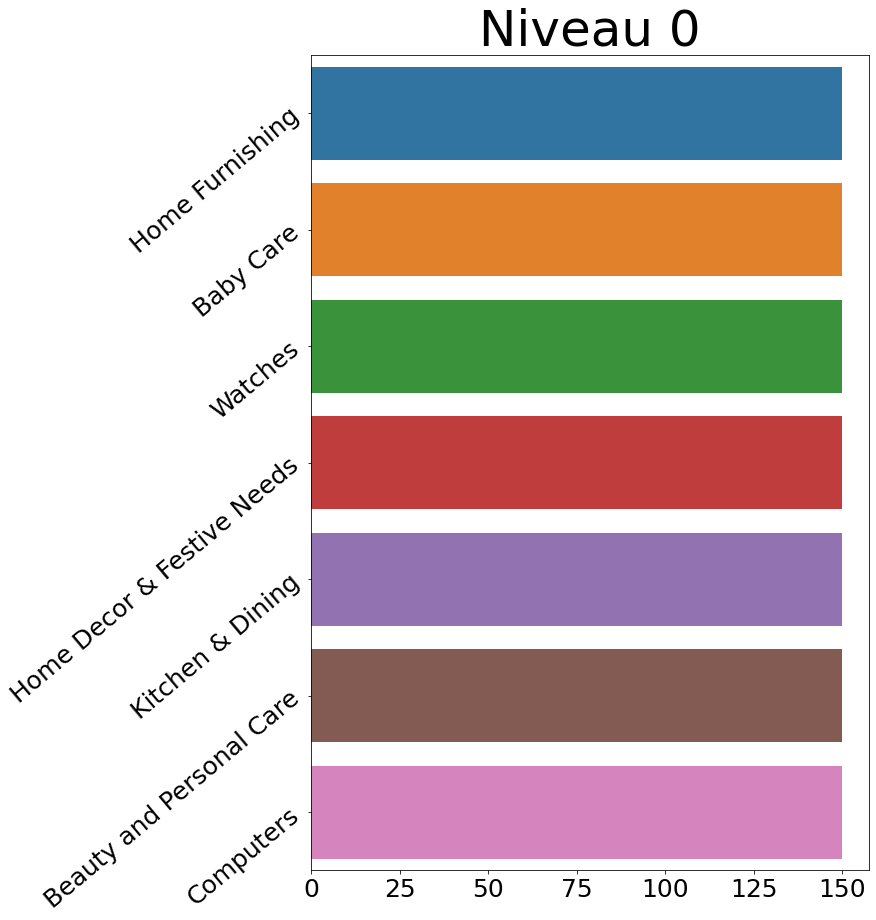

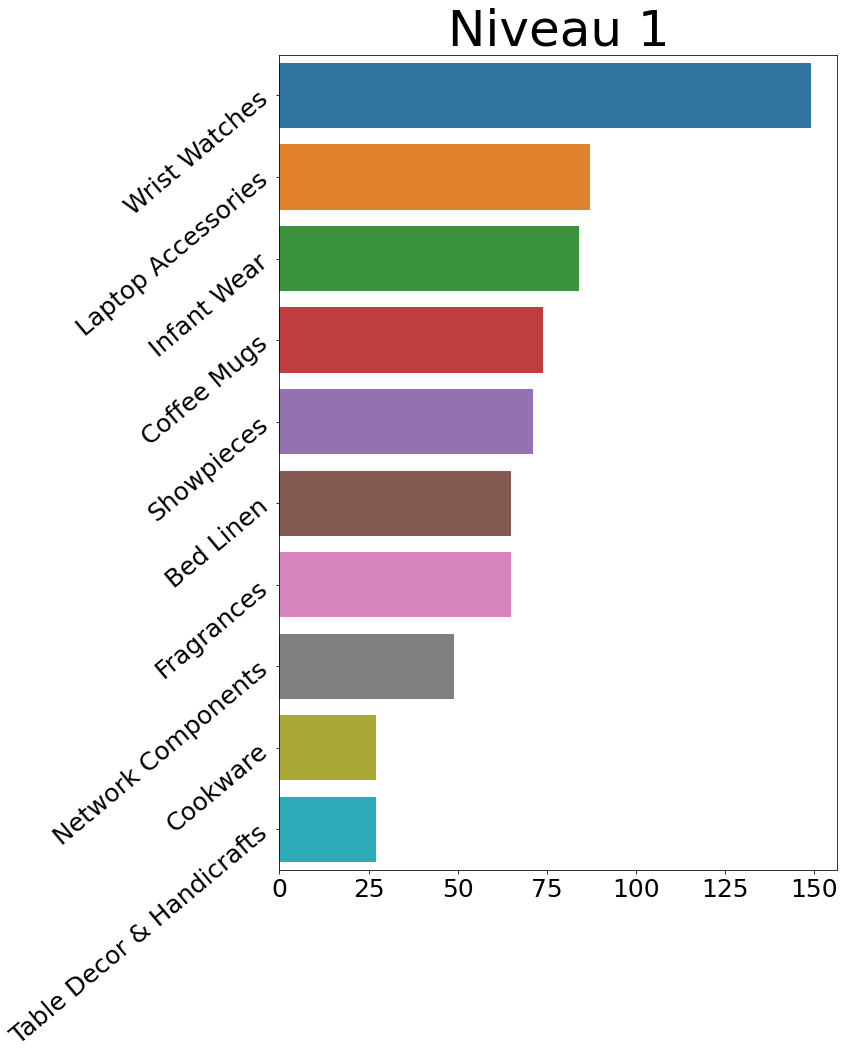

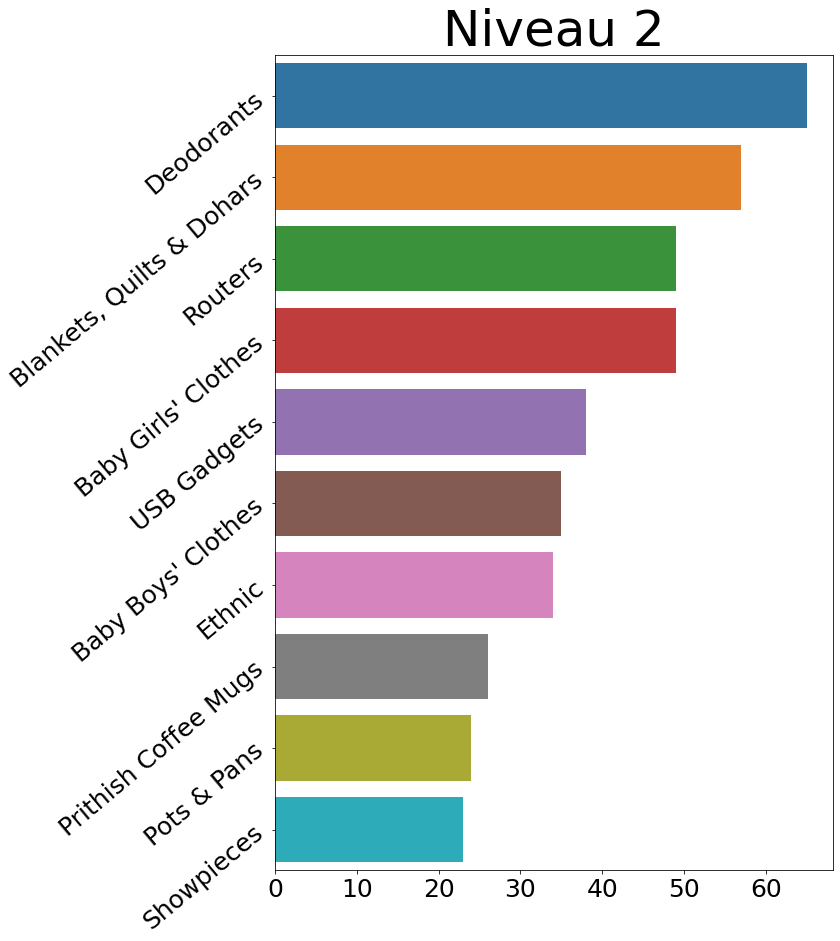

In [12]:
#Visualisation de la distribution des catégories 
plt.figure(figsize=(10, 15))
cat0 = sns.countplot(y=data['category_tree_level_0'],
                     order=data['category_tree_level_0'].value_counts().iloc[:10].index,
                     palette='tab10')
cat0.axes.set_title("Niveau 0",fontsize=50)
cat0.set_ylabel("",fontsize=20)
cat0.set_xlabel("",fontsize=20)
plt.yticks(rotation=40)
cat0.tick_params(labelsize=25)
plt.savefig("niveau_0.png", bbox_inches="tight")
plt.show()

plt.figure(figsize=(10, 15))
cat1 = sns.countplot(y=data['category_tree_level_1'],
                     order=data['category_tree_level_1'].value_counts().iloc[:10].index,
                     palette='tab10')
cat1.axes.set_title("Niveau 1",fontsize=50)
cat1.set_ylabel("",fontsize=20)
cat1.set_xlabel("",fontsize=20)
plt.yticks(rotation=40)
cat1.tick_params(labelsize=25)
plt.savefig("niveau_1.png", bbox_inches="tight")
plt.show()

plt.figure(figsize=(10, 15))
cat2 = sns.countplot(y=data['category_tree_level_2'],
                     order=data['category_tree_level_2'].value_counts().iloc[:10].index,
                     palette='tab10')
cat2.axes.set_title("Niveau 2",fontsize=50)
cat2.set_ylabel("",fontsize=20)
cat2.set_xlabel("",fontsize=20)
plt.yticks(rotation=40)
cat2.tick_params(labelsize=25)
plt.savefig("niveau_2.png", bbox_inches="tight")
plt.show()


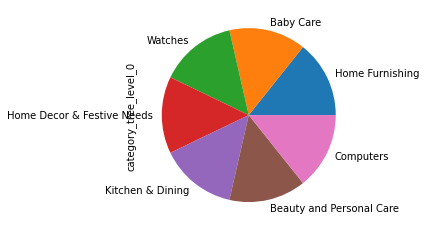

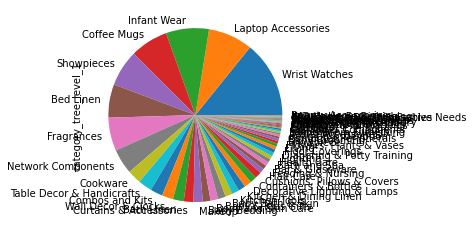

<function matplotlib.pyplot.show(close=None, block=None)>

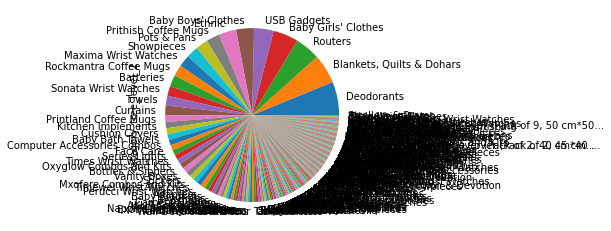

In [13]:
#Visualisation de la distribution des catégories en pie charte
data['category_tree_level_0'].value_counts().plot.pie()
plt.show()
data['category_tree_level_1'].value_counts().plot.pie()
plt.show()
data['category_tree_level_2'].value_counts().plot.pie()
plt.show

In [203]:
# Dictionnaire des résultats, key: nom méthode, value : ARI Score
scores = {}

# Dictionnaire de méthode pour la conservation des modèles
results_txt = {}
results_img = {}

# II. 1. Traitement de texte

In [14]:
# Fonction de preprocess
def preprocess(text):
    """Fonction de preprocessing"""
    import re
    from nltk.tokenize import word_tokenize
    from nltk.stem import WordNetLemmatizer, PorterStemmer
    
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(text))

    #Normalize tabs and remove newlines
    no_tabs = str(document).replace('\t', ' ').replace('\n', '');

    #Remove all characters except A-Z and a dot
    alphas_only = re.sub("[^a-zA-Z]", " ", no_tabs);

    #Normalize spaces to 1
    multi_spaces = re.sub(" +", " ", alphas_only);
    
    #Strip trailing and leading spaces
    no_spaces = multi_spaces.strip();

    #Normalize all charachters to lowercase
    clean_text = no_spaces.lower();

    #Tokenization
    tokens = word_tokenize(clean_text)
    
    # Lematization
    wl = WordNetLemmatizer()
    lemed = [wl.lemmatize(word) for word in tokens]
    
    # Removed words less than 3 characters
    lemed_1 = [word for word in lemed if len(word)>2]
    
    # Remove stopwords
    
    from sklearn.feature_extraction import text
    
    filtered_sentence = [w for w in lemed_1 if w not in text.ENGLISH_STOP_WORDS]
    
    return filtered_sentence

In [15]:
# Création de colonnes de preprocess
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

# Premier filtrage des mots
data['description_preprocess_1'] = data['description'].apply(preprocess)
data['product_name_preprocess_1'] = data['product_name'].apply(preprocess)

# Remise en place des list mots en string avec postag
data['description_preprocess_2'] = data['description_preprocess_1'].apply(' '.join)
data['product_name_preprocess_2'] = data['product_name_preprocess_1'].apply(' '.join)


In [16]:
data

uniq_id            crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url  \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid  \
0     ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
0           1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1            600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2              NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3           2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4           2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045        1399.0             999.0  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046        4930.0            1896.0  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1

In [17]:
# Fonction ajout de n fois produc_name à description

def add_n_name(n, dfname=data['product_name_preprocess_2'],
               df=data['description_preprocess_2']):
    """Fonction d'ajout de product name nfois'"""
    dfnameb = dfname + ' '
    df_final = n*dfnameb + df
    
    return df_final

# II. 2. Bag of Word (TF-IDF)

In [149]:
# Optimiser des hyperparamètres

Max_df = [1.0, 0.9, 0.8]
Min_df = [2, 4, 5]
perplexity = [10, 30, 50]
Ngram = [(1, 1), (1, 2), (2, 2)]
ARI_score_1 = []
final_param_1 = []
for n in range(2):
    df=add_n_name(n)
    for max_df in Max_df:
        for min_df in Min_df:
            for ngram in Ngram:
                for perp in perplexity:
                    # TFIDF
                    from sklearn.feature_extraction.text import TfidfVectorizer

                    tfidf = TfidfVectorizer(tokenizer=preprocess,
                                            max_df=max_df,
                                            min_df=min_df,
                                            ngram_range=ngram,
                                            stop_words={'english'})
                    values = tfidf.fit_transform(df)

                    # Réduction de dimension par t-SNE
                    from sklearn.manifold import TSNE

                    tsne = TSNE(n_components=2, 
                                perplexity=perp,
                                random_state=5)

                    tsne_results = tsne.fit_transform(values) 

                    # KMeans sur les 7 catégories
                    from sklearn.cluster import KMeans
                    from statistics import mean

                    kmodel = KMeans(n_clusters=7, random_state=5)
                    kmodel.fit(tsne_results)
                    data_km = data.copy()
                    data_km['kmeans_labels'] = kmodel.labels_

                    # Score ARI
                    from sklearn.metrics import adjusted_rand_score

                    ARI = adjusted_rand_score(data['category_tree_level_0'],
                                              data_km['kmeans_labels'])

                    # Enregistrement paramètres et score
                    ARI_score_1.append(ARI)
                    final_param_1.append((n, min_df, max_df, perp, ngram))

In [150]:
# Meilleurs score ARI et paramètres
print(f"Meilleur ARI = {max(ARI_score_1)}")

Meilleur ARI = 0.6055099627600043


In [151]:
# Détermination des meilleurs paramètres pour max ARI
i1 = [i for i, j in enumerate(ARI_score_1) if j == max(ARI_score_1)]
for i in i1:
    print(f"(n, min_df, max_df, perplexity, ngram_range) = {final_param_1[i]}")

(n, min_df, max_df, perplexity, ngram_range) = (1, 2, 1.0, 30, (1, 1))
(n, min_df, max_df, perplexity, ngram_range) = (1, 2, 0.9, 30, (1, 1))
(n, min_df, max_df, perplexity, ngram_range) = (1, 2, 0.8, 30, (1, 1))


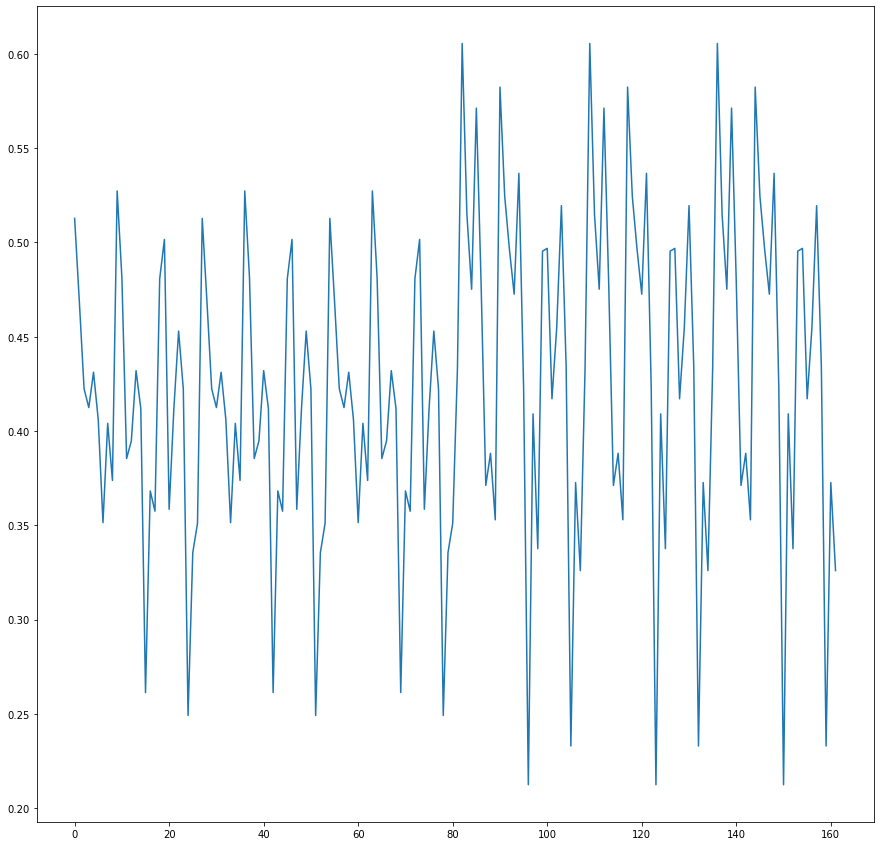

In [153]:
# Evolution de ARI score en fonction des paramètres
plt.figure(figsize=(15,15))
plt.plot(ARI_score_1)
plt.show()

ARI = 0.6055099627600043


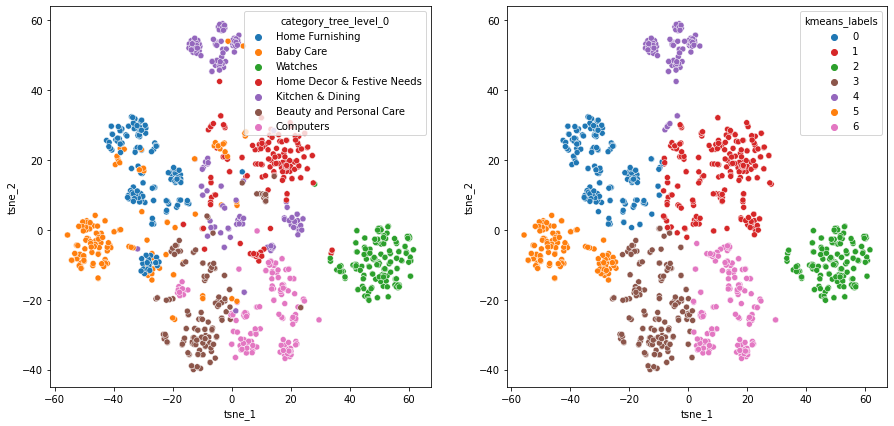

In [371]:
# Appliquer des hyperparamètres optimisées

# TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=preprocess,
                        ngram_range=(1, 1),
                        max_df=1.0,
                        min_df=2,
                        stop_words={'english'})
values_bow = tfidf.fit_transform(add_n_name(n=1))

# Réduction de dimension par t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=5)
tsne_results_bow = tsne.fit_transform(values_bow) 

# KMeans sur les 7 catégories
from sklearn.cluster import KMeans

kmodel = KMeans(n_clusters=7, random_state=5)
kmodel.fit(tsne_results_bow)
data_km = data.copy()
data_km['kmeans_labels'] = kmodel.labels_

# Score ARI
from sklearn.metrics import adjusted_rand_score


ARI = adjusted_rand_score(data['category_tree_level_0'],
                          data_km['kmeans_labels'])

print(f"ARI = {ARI}")

# Plot des samples dans t-SNE plot
data_km['tsne_1'] = tsne_results_bow[:, 0]
data_km['tsne_2'] = tsne_results_bow[:, 1]
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plot = sns.scatterplot(x="tsne_1",
                       y="tsne_2",
                       hue='category_tree_level_0',
                       palette='tab10',
                       data=data_km,
                       legend="full")

color = {0: "tab:blue", 1:"tab:red", 2:"tab:green", 3:"tab:brown",
          4:"tab:purple", 5:"tab:orange", 6:"tab:pink"}

plt.subplot(1, 2, 2)
plot = sns.scatterplot(x="tsne_1",
                       y="tsne_2",
                       hue='kmeans_labels',
                       palette= color,
                       data=data_km,
                       legend="full")

plt.savefig("tfidf_tsne.png", bbox_inches="tight")
plt.show()

In [211]:
scores['TF-IDF'] = ARI
results_txt['TF-IDF']= tsne_results_bow

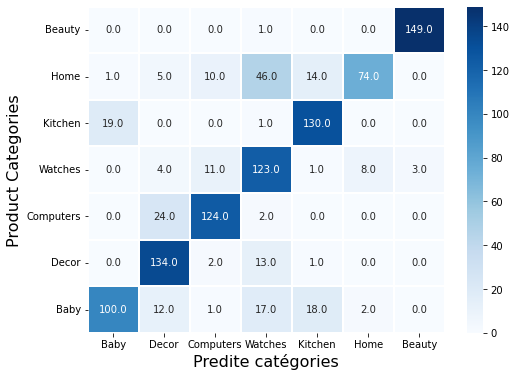

In [329]:
# Les catégories d'images sont encodés numériquement de 0 à 6
cat_encoder = LabelEncoder()
y_true = cat_encoder.fit_transform(data['category_tree_level_0'])

# Labels prédits par le meilleur algorithme
km = KMeans(n_clusters=data['category_tree_level_0'].nunique())
y_pred = km.fit_predict(results_txt["TF-IDF"])

# Calcul de la Matrice de confusion
mat_conf = confusion_matrix(y_true, y_pred)

# transform matrice de confusion
corresp = np.argmax(mat_conf, axis=0)
labels = pd.Series(y_true, name="y_true").to_frame()
labels['y_pred'] = y_pred
labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])
mat_conf_transform = metrics.confusion_matrix(y_true, labels['y_pred_transform'])

# Mise sous forme de DataFrame
list_labels=['Baby','Decor','Computers','Watches','Kitchen','Home','Beauty']
mat_conf_df = pd.DataFrame(mat_conf_transform,index = [label for label in list_labels],
                  columns = [label for label in list_labels])
# Trace la matrice de confusion
fig = plt.figure(1, figsize=(8, 6))
sns.heatmap(mat_conf_df, annot=True, linewidths=.3, fmt='.1f', cmap="Blues")
plt.ylabel('Product Categories', fontsize = 16)
plt.xlabel('Predite catégories', fontsize = 16)
plt.ylim(0, 7)
plt.show()

## TF-IDF (essayer pca + t-sne)

In [190]:
# Optimiser des hyperparamètres

Max_df = [1.0, 0.9, 0.8]
Min_df = [2, 4, 5]
perplexity = [10, 30, 50]
Ngram = [(1, 1), (1, 2), (2, 2)]
variance = [0.95, 0.9, 0.8]
ARI_score_2 = []
final_param_2 = []
for n in range(2):
    df=add_n_name(n=n)
    for max_df in Max_df:
        for min_df in Min_df:
            for ngram in Ngram:
                for var in variance:
                    for perp in perplexity:
                        # TFIDF
                        from sklearn.feature_extraction.text import TfidfVectorizer

                        tfidf = TfidfVectorizer(tokenizer=preprocess,
                                                max_df=max_df,
                                                min_df=min_df,
                                                ngram_range=ngram,
                                                stop_words={'english'})
                        values = tfidf.fit_transform(df)
                        values = values.toarray()
                
                        # Réduction de dimension par ACP
                        from sklearn.decomposition import PCA
                
                        pca = PCA(n_components= var)
                        values = pca.fit_transform(values)

                        # Réduction de dimension par t-SNE
                        from sklearn.manifold import TSNE

                        tsne = TSNE(n_components=2, 
                                    perplexity=perp,
                                    random_state=5)

                        tsne_results = tsne.fit_transform(values) 

                        # KMeans sur les 7 catégories
                        from sklearn.cluster import KMeans
                        from statistics import mean

                        kmodel = KMeans(n_clusters=7, random_state=5)
                        kmodel.fit(tsne_results)
                        data_km = data.copy()
                        data_km['kmeans_labels'] = kmodel.labels_

                        # Score ARI
                        from sklearn.metrics import adjusted_rand_score

                        ARI = adjusted_rand_score(data['category_tree_level_0'],
                                                  data_km['kmeans_labels'])

                        # Enregistrement paramètres et score
                        ARI_score_2.append(ARI)
                        final_param_2.append((n, min_df, max_df, perp, ngram, var))

In [191]:
# Meilleurs score ARI et paramètres
print(f"Meilleur ARI = {max(ARI_score_2)}")

Meilleur ARI = 0.5805853891051889


In [192]:
# Détermination des meilleurs paramètres pour max ARI
i1 = [i for i, j in enumerate(ARI_score_2) if j == max(ARI_score_2)]
for i in i1:
    print(f"(n, min_df, max_df, perp, ngram, var) = {final_param_2[i]}")

(n, min_df, max_df, perp, ngram, var) = (0, 4, 1.0, 10, (1, 1), 0.95)
(n, min_df, max_df, perp, ngram, var) = (0, 4, 0.9, 10, (1, 1), 0.95)
(n, min_df, max_df, perp, ngram, var) = (0, 4, 0.8, 10, (1, 1), 0.95)


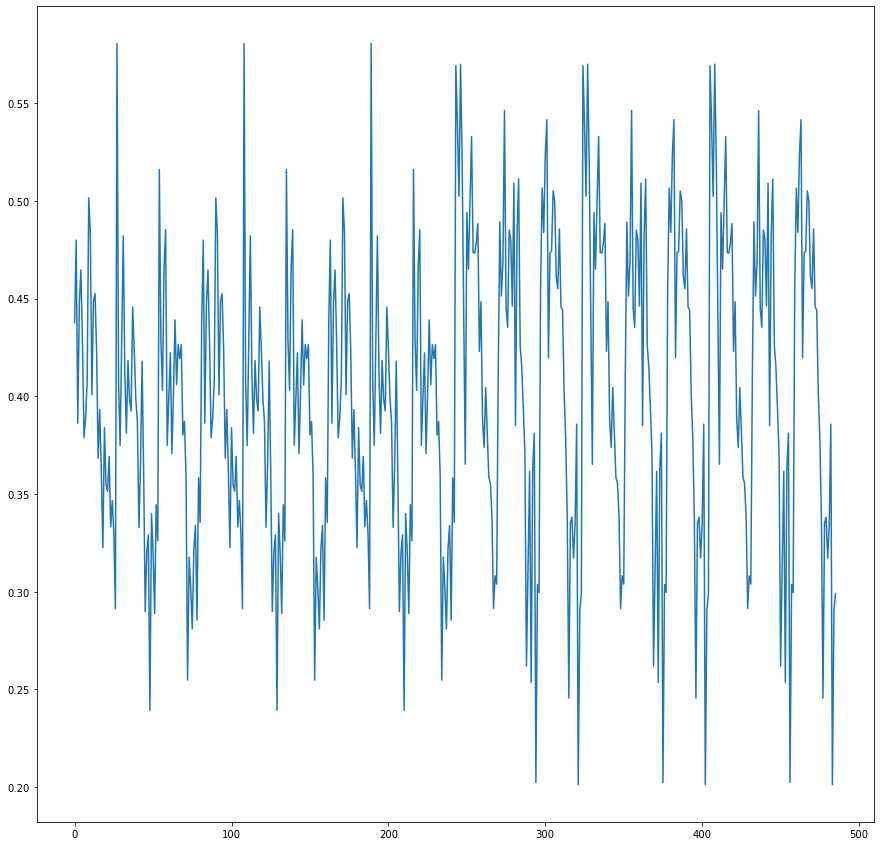

In [194]:
# Evolution de ARI score en fonction des paramètres
plt.figure(figsize=(15,15))
plt.plot(ARI_score_2)
plt.show()

In [203]:
# Appliquer des hyperparamètres optimisées

# TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=preprocess,
                        ngram_range=(1, 1),
                        max_df=0.9,
                        min_df=4,
                        stop_words={'english'})
values_bow2 = tfidf.fit_transform(add_n_name(n=0))
values_bow2= values_bow2.toarray()

# Réduction de dimension par ACP
from sklearn.decomposition import PCA
pca = PCA(n_components= 0.95)
values_bow2 = pca.fit_transform(values_bow2)

# Réduction de dimension par t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=10, random_state=5)
tsne_results_bow2 = tsne.fit_transform(values_bow2)

# KMeans sur les 7 catégories
from sklearn.cluster import KMeans

kmodel = KMeans(n_clusters=7, random_state=5)
kmodel.fit(tsne_results_bow2)
data_km = data.copy()
data_km['kmeans_labels'] = kmodel.labels_

# Score ARI
from sklearn.metrics import adjusted_rand_score


ARI = adjusted_rand_score(data['category_tree_level_0'],
                          data_km['kmeans_labels'])

print(f"ARI = {ARI}")

ARI = 0.5805853891051889


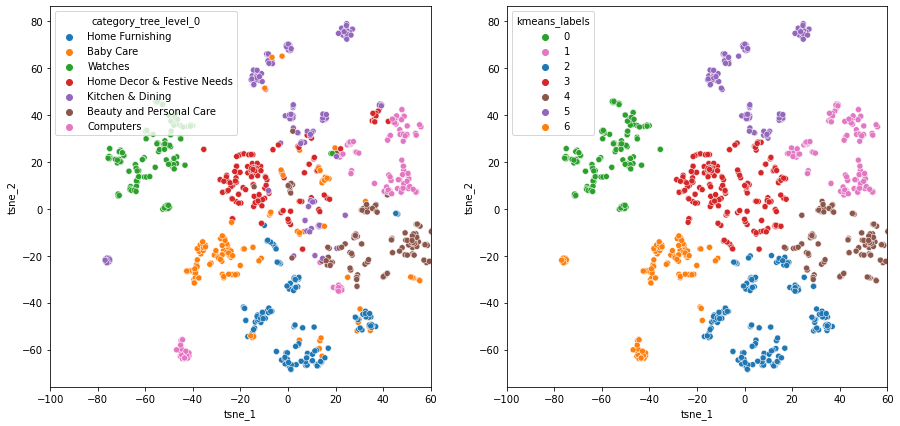

In [205]:
# Plot des samples dans t-SNE plot
data_km['tsne_1'] = tsne_results_bow2[:, 0]
data_km['tsne_2'] = tsne_results_bow2[:, 1]
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plot = sns.scatterplot(x="tsne_1",
                       y="tsne_2",
                       hue='category_tree_level_0',
                       palette='tab10',
                       data=data_km,
                       legend="full")


color = {0: "tab:green", 1:"tab:pink", 2:"tab:blue", 3:"tab:red",
          4:"tab:brown", 5:"tab:purple", 6:"tab:orange"}
plt.subplot(1, 2, 2)
plot = sns.scatterplot(x="tsne_1",
                       y="tsne_2",
                       hue='kmeans_labels',
                       palette= color,
                       data=data_km,
                       legend="full")

plt.savefig("tfidf_tsne.png", bbox_inches="tight")
plt.show()

# II. 3. Word2Vec

In [213]:
def sent_vectorizer(sent, model):
    """Vectorisation des listes de mots"""
    sent_vec =[]
    numw = 0
    for w in sent:
        try:
            if numw == 0:
                sent_vec = model.wv[w]
            else:
                sent_vec = np.add(sent_vec, model.wv[w])
            numw+=1
        except:
            pass
         
    return np.asarray(sent_vec) / numw


In [209]:
# Optimiser des hyperparamètres

Size = [50, 100, 200]
Window = [10, 20, 30]
Min_count = [2, 5, 10]
perplexity = [10, 30, 50]

ARI_score_3 = []
final_param_3 = []
for n in range(2):
    df=add_n_name(n=n)
    df1=df.apply(word_tokenize)
    for size in Size:
        for window in Window:
            for min_count in Min_count:
                for perp in perplexity:
                    from gensim.models import Word2Vec
                    from gensim.models.fasttext import FastText
                    w2v = Word2Vec(df1,
                               sg=1,
                               seed=1,
                               vector_size=size,
                               window=window,
                               min_count=min_count,
                               batch_words=5000,
                               sample=1e-3,
                               workers=1)
                    X=[]
                    for sentence in df1:
                        X.append(sent_vectorizer(sentence, w2v))

                    tsne = TSNE(n_components=2, perplexity=perp,
                               random_state=5)
                    tsne_results = tsne.fit_transform(X)

                    # KMeans sur les 7 catégories
                    from sklearn.cluster import KMeans
                    from statistics import mean

                    kmodel = KMeans(n_clusters=7, random_state=5)
                    kmodel.fit(tsne_results)
                    data_km = data.copy()
                    data_km['kmeans_labels'] = kmodel.labels_
                
                    # Score ARI
                    from sklearn.metrics import adjusted_rand_score
                    ARI = adjusted_rand_score(data['category_tree_level_0'],
                                              data_km['kmeans_labels'])
            
                    # Enregistrement paramètres et score
                    ARI_score_3.append(ARI)
                    final_param_3.append((n, size, window, min_count, perp))

In [210]:

# Meilleurs score ARI et paramètres
print(f"Meilleur ARI = {max(ARI_score_3)}")

Meilleur ARI = 0.42878886735158783


In [211]:
# Détermination des meilleurs paramètres pour max ARI
i2 = [i for i, j in enumerate(ARI_score_3) if j == max(ARI_score_3)]
for i in i2:
    print(f"(n, size, window, min_count, perplexity) = {final_param_3[i]}")

(n, size, window, min_count, perplexity) = (1, 100, 30, 10, 10)


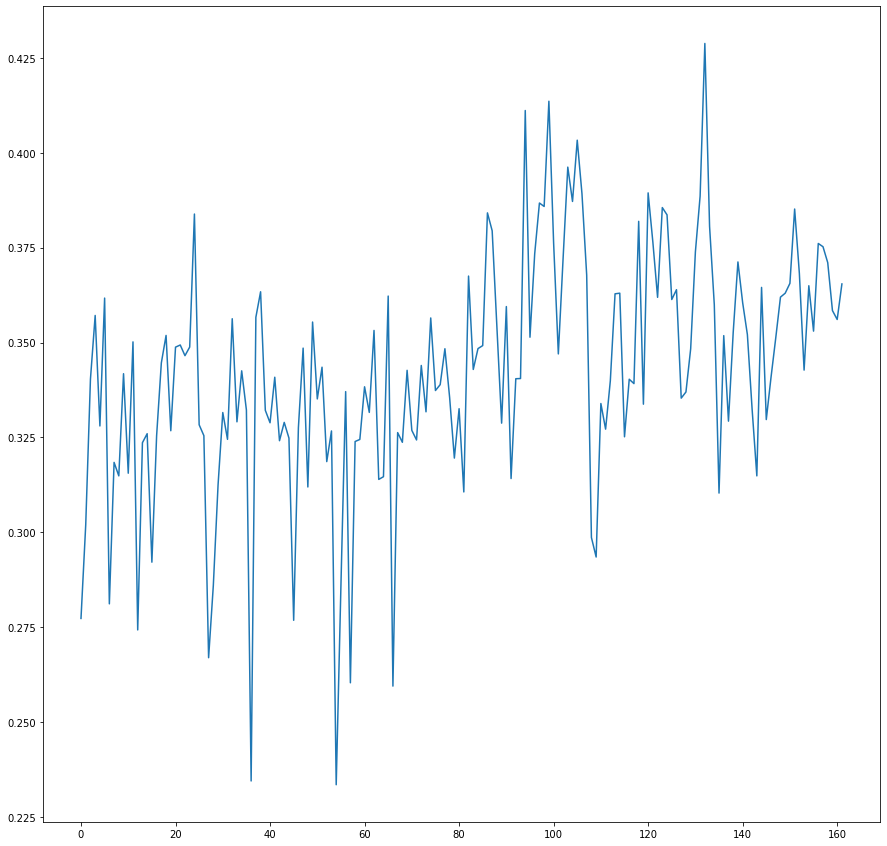

In [215]:
# Evolution de ARI score en fonction des paramètres
plt.figure(figsize=(15,15))
plt.plot(ARI_score_3)
plt.show()

In [374]:
# Appliquer des hyperparamètres optimisées

df = add_n_name(n=1)
df1=df.apply(word_tokenize)
w2v = Word2Vec(df1,
               sg=1,
               seed=1,
               vector_size=100,
               window=30,
               batch_words=5000,
               min_count=10,
               sample=1e-3,
               workers=1)
X_w2v=[]
for sentence in df1:
    X_w2v.append(sent_vectorizer(sentence, w2v)) 

# Réduction de dimension par t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=10,
            random_state=5)
tsne_results_w2v = tsne.fit_transform(X_w2v) 

# KMeans sur les 7 catégories
from sklearn.cluster import KMeans

kmodel = KMeans(n_clusters=7, random_state=5)
kmodel.fit(tsne_results_w2v)
data_km = data.copy()
data_km['kmeans_labels'] = kmodel.labels_

# Score ARI
from sklearn.metrics import adjusted_rand_score

ARI = adjusted_rand_score(data['category_tree_level_0'],
                          data_km['kmeans_labels'])
db_score = davies_bouldin_score(tsne_results_w2v, data_km['kmeans_labels'])

print(f"ARI = {ARI}")

ARI = 0.42878886735158783


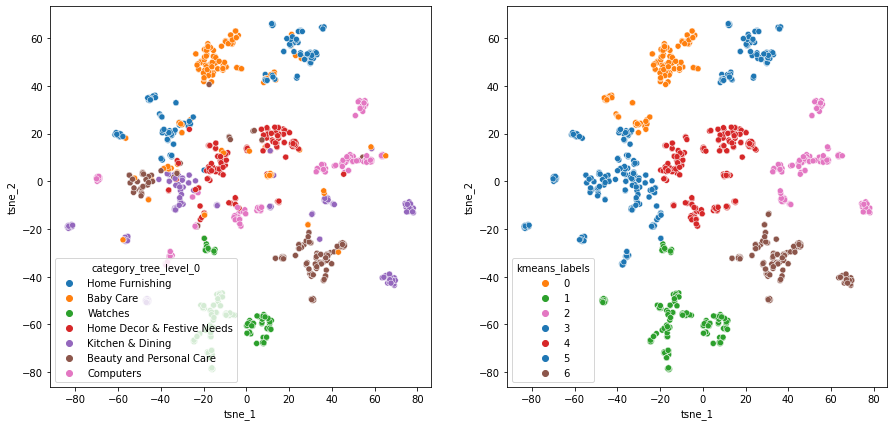

In [377]:

# Plot des samples dans t-SNE plot
data_km['tsne_1'] = tsne_results_w2v[:, 0]
data_km['tsne_2'] = tsne_results_w2v[:, 1]
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plot = sns.scatterplot(x="tsne_1",
                       y="tsne_2",
                       hue='category_tree_level_0',
                       palette='tab10',
                       data=data_km,
                       legend="full")


color = {0: "tab:orange", 1:"tab:green", 2:"tab:pink", 3:"tab:blue",
          4:"tab:red", 5:"tab:blue", 6:"tab:brown"}
plt.subplot(1, 2, 2)
plot = sns.scatterplot(x="tsne_1",
                       y="tsne_2",
                       hue='kmeans_labels',
                       palette=color,
                       data=data_km,
                       legend="full")

plt.savefig("w2v_tsne.png", bbox_inches="tight")
plt.show()

## Word2Vec (Utiliser pca + t-sne)

In [30]:
# Optimiser des hyperparamètres

Size = [50, 100]
Window = [10, 20]
Min_count = [2, 5, 10]
variance = [0.9, 0.95]
perplexity = [30, 10]

ARI_score_4 = []
final_param_4 = []
for n in range(2):
    df=add_n_name(n=n)
    df1=df.apply(word_tokenize)
    for size in Size:
        for window in Window:
            for min_count in Min_count:
                
                from gensim.models import Word2Vec
                from gensim.models.fasttext import FastText
                w2v = Word2Vec(df1,
                               sg=1,
                               seed=1,
                               vector_size=size,
                               window=window,
                               min_count=min_count,
                               batch_words=5000,
                               sample=1e-3,
                               workers=1)
                X=[]
                for sentence in df1:
                    X.append(sent_vectorizer(sentence, w2v))
                
                for var in variance:
                    
                    pca = PCA(n_components= var)
                    X = pca.fit_transform(X)
                    
                    for perp in perplexity:
                        from sklearn.manifold import TSNE

                        tsne = TSNE(n_components=2, perplexity=perp,
                                   random_state=5)
                        tsne_results = tsne.fit_transform(X)

                        # KMeans sur les 7 catégories
                        from sklearn.cluster import KMeans
                        from statistics import mean

                        kmodel = KMeans(n_clusters=7, random_state=5)
                        kmodel.fit(tsne_results)
                        data_km = data.copy()
                        data_km['kmeans_labels'] = kmodel.labels_
                
                        # Score ARI
                        from sklearn.metrics import adjusted_rand_score
                        ARI = adjusted_rand_score(data['category_tree_level_0'],
                                                  data_km['kmeans_labels'])
            
                        # Enregistrement paramètres et score
                        ARI_score_4.append(ARI)
                        final_param_4.append((n, size, window, min_count, var, perp))

In [31]:
# Meilleurs score ARI et paramètres
print(f"Meilleur ARI = {max(ARI_score_4)}")

Meilleur ARI = 0.45439000548063657


In [35]:
# Détermination des meilleurs paramètres pour max ARI
i2 = [i for i, j in enumerate(ARI_score_4) if j == max(ARI_score_4)]
for i in i2:
    print(f"(n, size, window, min_count, var, perplexity) = {final_param_4[i]}")

(n, size, window, min_count, var, perplexity) = (1, 100, 20, 5, 0.95, 10)


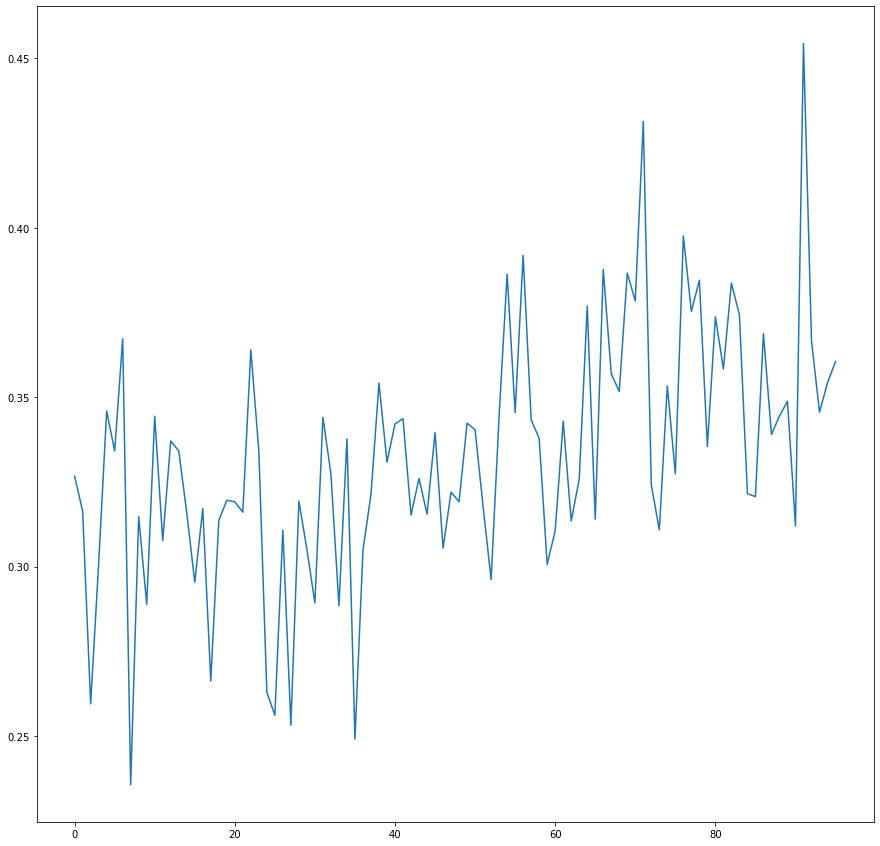

In [33]:
# Evolution de ARI score en fonction des paramètres
plt.figure(figsize=(15,15))
plt.plot(ARI_score_4)
plt.show()

In [215]:
# Appliquer des hyperparamètres optimisées

df=add_n_name(n=1)
df1=df.apply(word_tokenize)
w2v = Word2Vec(df1,
               sg=1,
               seed=1,
               vector_size=100,
               window=20,
               batch_words=5000,
               min_count=5,
               sample=1e-3,
               workers=1)
X_w2v=[]
for sentence in df1:
    X_w2v.append(sent_vectorizer(sentence, w2v)) 

# Réduction de dimension par t-SNE
from sklearn.manifold import TSNE

pca = PCA(n_components= 0.95)
X_w2v = pca.fit_transform(X_w2v)
tsne = TSNE(n_components=2, perplexity=10,
            random_state=5)
tsne_results_w2v = tsne.fit_transform(X_w2v) 

# KMeans sur les 7 catégories
from sklearn.cluster import KMeans

kmodel = KMeans(n_clusters=7, random_state=5)
kmodel.fit(tsne_results_w2v)
data_km = data.copy()
data_km['kmeans_labels'] = kmodel.labels_

# Score ARI

ARI = adjusted_rand_score(data['category_tree_level_0'],
                          data_km['kmeans_labels'])

print(f"ARI = {ARI}")

ARI = 0.43031635495525483


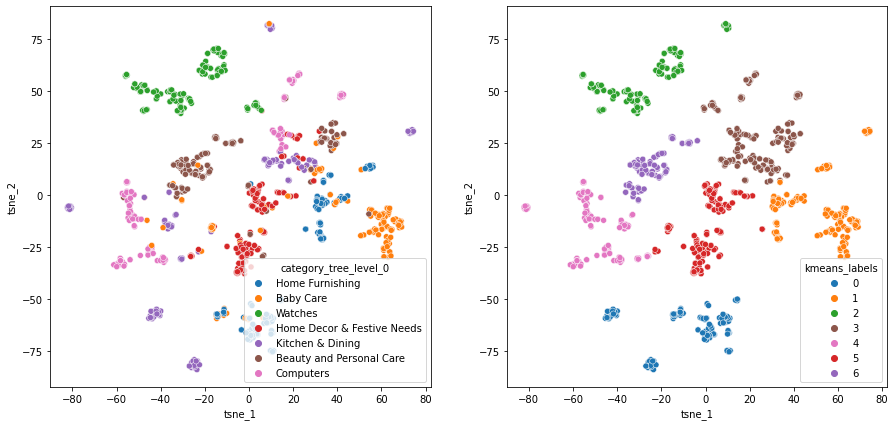

In [40]:

# Plot des samples dans t-SNE plot
data_km['tsne_1'] = tsne_results_w2v[:, 0]
data_km['tsne_2'] = tsne_results_w2v[:, 1]
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plot = sns.scatterplot(x="tsne_1",
                       y="tsne_2",
                       hue='category_tree_level_0',
                       palette='tab10',
                       data=data_km,
                       legend="full")


color = {0: "tab:blue", 1:"tab:orange", 2:"tab:green", 3:"tab:brown",
          4:"tab:pink", 5:"tab:red", 6:"tab:purple"}
plt.subplot(1, 2, 2)
plot = sns.scatterplot(x="tsne_1",
                       y="tsne_2",
                       hue='kmeans_labels',
                       palette=color,
                       data=data_km,
                       legend="full")

plt.savefig("w2v_tsne.png", bbox_inches="tight")
plt.show()

In [216]:
scores['Word2Vec'] = ARI
results_txt['Word2Vec']= tsne_results_w2v

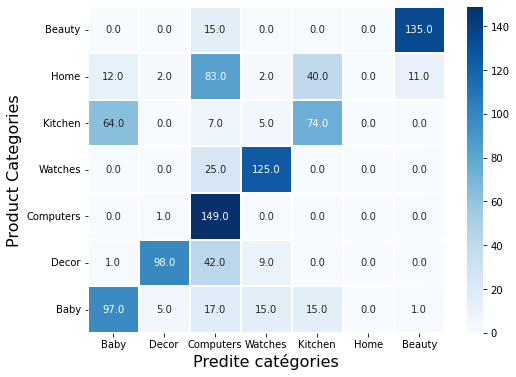

In [330]:
# Les catégories d'images sont encodés numériquement de 0 à 6
cat_encoder = LabelEncoder()
y_true = cat_encoder.fit_transform(data['category_tree_level_0'])

# Labels prédits par le meilleur algorithme
km = KMeans(n_clusters=data['category_tree_level_0'].nunique())
y_pred = km.fit_predict(results_txt["Word2Vec"])

# Calcul de la Matrice de confusion
mat_conf = confusion_matrix(y_true, y_pred)

# transform matrice de confusion
corresp = np.argmax(mat_conf, axis=0)
labels = pd.Series(y_true, name="y_true").to_frame()
labels['y_pred'] = y_pred
labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])
mat_conf_transform = metrics.confusion_matrix(y_true, labels['y_pred_transform'])

# Mise sous forme de DataFrame
list_labels=['Baby','Decor','Computers','Watches','Kitchen','Home','Beauty']
mat_conf_df = pd.DataFrame(mat_conf_transform,index = [label for label in list_labels],
                  columns = [label for label in list_labels])
# Trace la matrice de confusion
fig = plt.figure(1, figsize=(8, 6))
sns.heatmap(mat_conf_df, annot=True, linewidths=.3, fmt='.1f', cmap="Blues")
plt.ylabel('Product Categories', fontsize = 16)
plt.xlabel('Predite catégories', fontsize = 16)
plt.ylim(0, 7)
plt.show()

## Word2Vec (Utiliser seulement pca)

In [46]:
# Optimiser des hyperparamètres

Size = [100, 50]
Window = [10, 20, 30]
Min_count = [2, 5, 10]
variance = [0.9, 0.8, 0.95]

ARI_score_5 = []
final_param_5 = []
for n in range(2):
    df=add_n_name(n=n)
    df1=df.apply(word_tokenize)
    for size in Size:
        for window in Window:
            for min_count in Min_count:
                
                from gensim.models import Word2Vec
                from gensim.models.fasttext import FastText
                w2v = Word2Vec(df1,
                               sg=1,
                               seed=1,
                               vector_size=size,
                               window=window,
                               min_count=min_count,
                               batch_words=5000,
                               sample=1e-3,
                               workers=1)
                X=[]
                for sentence in df1:
                    X.append(sent_vectorizer(sentence, w2v))
                
                for var in variance:
                    
                    pca = PCA(n_components= var)
                    X = pca.fit_transform(X)


                    # KMeans sur les 7 catégories
                    from sklearn.cluster import KMeans
                    from statistics import mean

                    kmodel = KMeans(n_clusters=7, random_state=5)
                    kmodel.fit(X)
                    data_km = data.copy()
                    data_km['kmeans_labels'] = kmodel.labels_
                
                    # Score ARI
                    from sklearn.metrics import adjusted_rand_score
                    ARI = adjusted_rand_score(data['category_tree_level_0'],
                                          data_km['kmeans_labels'])
            
                    # Enregistrement paramètres et score
                    ARI_score_5.append(ARI)
                    final_param_5.append((n, size, window, min_count, var))

In [47]:
# Meilleurs score ARI et paramètres
print(f"Meilleur ARI = {max(ARI_score_5)}")

Meilleur ARI = 0.3499608924234685


In [48]:
# Détermination des meilleurs paramètres pour max ARI
i2 = [i for i, j in enumerate(ARI_score_5) if j == max(ARI_score_5)]
for i in i2:
    print(f"(n, size, window, min_count, var) = {final_param_5[i]}")

(n, size, window, min_count, var) = (1, 100, 20, 5, 0.8)
(n, size, window, min_count, var) = (1, 100, 20, 5, 0.95)


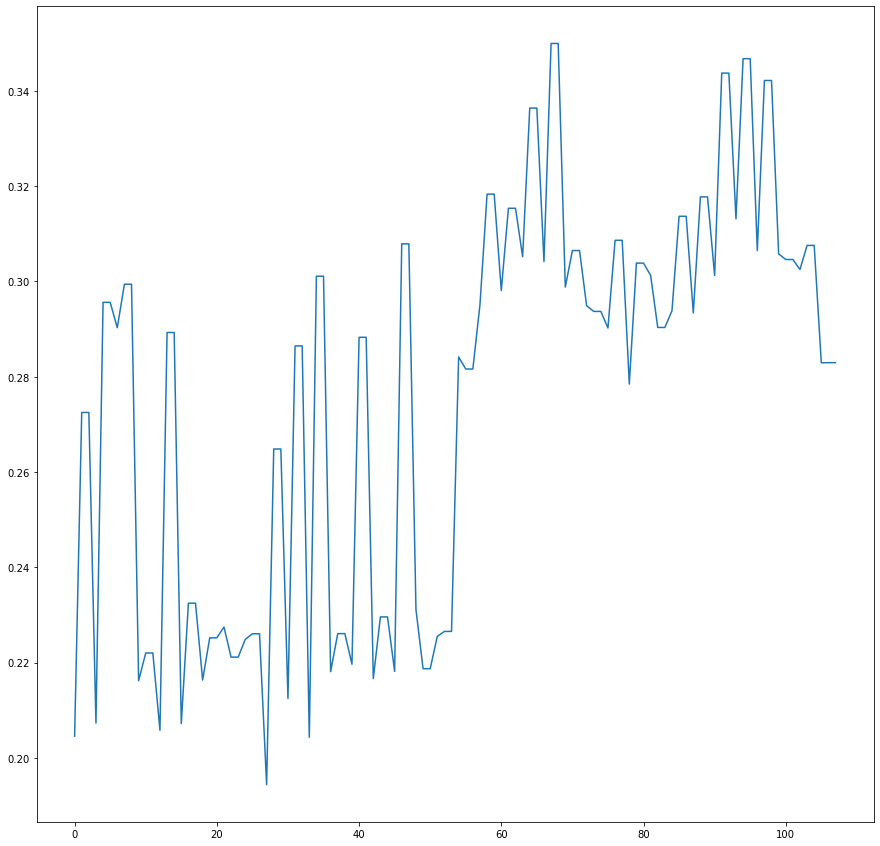

In [49]:
# Evolution de ARI score en fonction des paramètres
plt.figure(figsize=(15,15))
plt.plot(ARI_score_5)
plt.show()

# II. 4. Universel sentence embedding

In [219]:
import tensorflow as tens
import tensorflow_hub as hub

In [220]:
encoder = hub.load('https://tfhub.dev/google/universal-sentence-encoder-large/5')

In [73]:
# Optimiser des hyperparamètres

ARI_score_6 = []
perplexity = [30, 20, 10]
final_params_6 = []
for n in range(2):
    df = add_n_name(n=n)
    tf_tensor = encoder(df.values)
    df_use = pd.DataFrame(tens.make_ndarray(tens.make_tensor_proto(tf_tensor)),
                         index=df.index,
                         columns=['dim'+str(i) for i in range(512)])

    # Réduction de dimension par t-SNE
    from sklearn.manifold import TSNE

    for perp in perplexity:
        tsne = TSNE(n_components=2, perplexity=perp,
                    random_state=5)
        tsne_results = tsne.fit_transform(df_use) 

        # KMeans sur les 7 catégories
        from sklearn.cluster import KMeans

        kmodel = KMeans(n_clusters=7, random_state=5)
        kmodel.fit(tsne_results)
        data_kmuse = data.copy()
        data_kmuse['kmeans_labels'] = kmodel.labels_

        # Score ARI
        from sklearn.metrics import adjusted_rand_score
    
        ARI = adjusted_rand_score(data['category_tree_level_0'],
                              data_kmuse['kmeans_labels'])
    
        ARI_score_6.append(ARI)
        final_params_6.append((n, perp))

In [74]:
# Meilleurs score ARI et paramètres
print(f"Meilleur ARI = {max(ARI_score_6)}")

Meilleur ARI = 0.7092035867311872


In [75]:
# Détermination des meilleurs paramètres pour max ARI
i6 = [i for i, j in enumerate(ARI_score_6) if j == max(ARI_score_6)]
for i in i6:
    print(f"(n, perplexity) = {final_params_6[i]}")

(n, perplexity) = (1, 20)


In [221]:
# Appliquer des hyperparamètres optimisées

df = add_n_name(n=1)
tf_tensor = encoder(df.values)
df_use = pd.DataFrame(tens.make_ndarray(tens.make_tensor_proto(tf_tensor)),
                      index=df.index,
                      columns=['dim'+str(i) for i in range(512)])
# Réduction de dimension par t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=20,
            random_state=5)
tsne_results_use = tsne.fit_transform(df_use) 
# KMeans sur les 7 catégories
from sklearn.cluster import KMeans

kmodel = KMeans(n_clusters=7, random_state=5)
kmodel.fit(tsne_results_use)
data_kmuse = data.copy()
data_kmuse['kmeans_labels'] = kmodel.labels_
# Score ARI
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score

ARI = adjusted_rand_score(data['category_tree_level_0'],
                          data_kmuse['kmeans_labels'])

print(f"ARI = {ARI}")

ARI = 0.7092035867311872


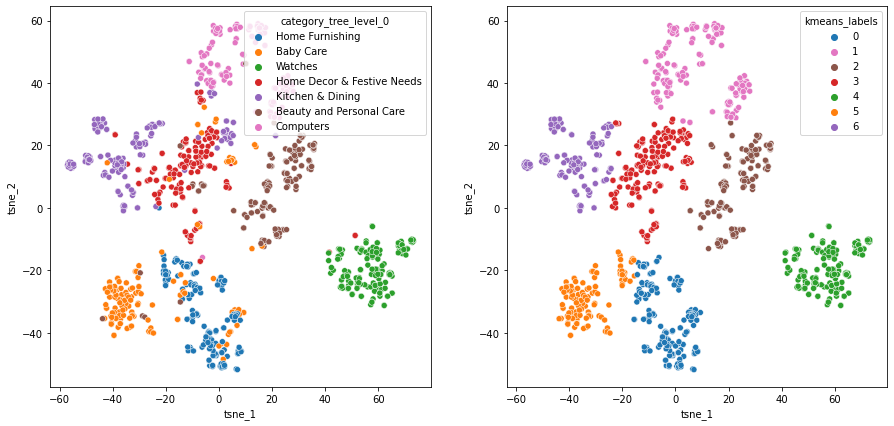

In [78]:
# Plot des samples dans t-SNE plot
data_kmuse['tsne_1'] = tsne_results_use[:, 0]
data_kmuse['tsne_2'] = tsne_results_use[:, 1]
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plot = sns.scatterplot(x="tsne_1",
                       y="tsne_2",
                       hue='category_tree_level_0',
                       palette='tab10',
                       data=data_kmuse,
                       legend="full")

color = {0: "tab:blue", 1:"tab:pink", 2:"tab:brown", 3:"tab:red",
          4:"tab:green", 5:"tab:orange", 6:"tab:purple"}
plt.subplot(1, 2, 2)
plot = sns.scatterplot(x="tsne_1",
                       y="tsne_2",
                       hue='kmeans_labels',
                       palette=color,
                       data=data_kmuse,
                       legend="full")

plt.savefig("w2v_tsne.png", bbox_inches="tight")
plt.show()

In [222]:
scores['USE'] = ARI
results_txt['USE']= tsne_results_use

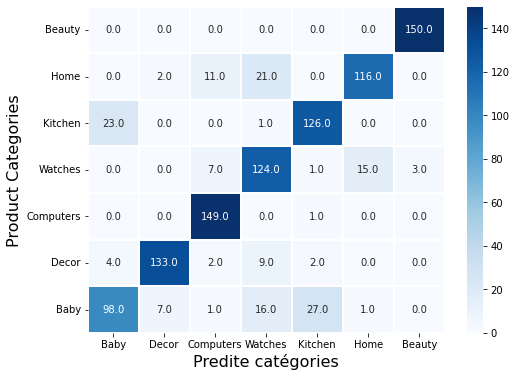

In [331]:
# Les catégories d'images sont encodés numériquement de 0 à 6
cat_encoder = LabelEncoder()
y_true = cat_encoder.fit_transform(data['category_tree_level_0'])

# Labels prédits par le meilleur algorithme
km = KMeans(n_clusters=data['category_tree_level_0'].nunique())
y_pred = km.fit_predict(results_txt["USE"])

# Calcul de la Matrice de confusion
mat_conf = confusion_matrix(y_true, y_pred)

# transform matrice de confusion
corresp = np.argmax(mat_conf, axis=0)
labels = pd.Series(y_true, name="y_true").to_frame()
labels['y_pred'] = y_pred
labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])
mat_conf_transform = metrics.confusion_matrix(y_true, labels['y_pred_transform'])

# Mise sous forme de DataFrame
list_labels=['Baby','Decor','Computers','Watches','Kitchen','Home','Beauty']
mat_conf_df = pd.DataFrame(mat_conf_transform,index = [label for label in list_labels],
                  columns = [label for label in list_labels])
# Trace la matrice de confusion
fig = plt.figure(1, figsize=(8, 6))
sns.heatmap(mat_conf_df, annot=True, linewidths=.3, fmt='.1f', cmap="Blues")
plt.ylabel('Product Categories', fontsize = 16)
plt.xlabel('Predite catégories', fontsize = 16)
plt.ylim(0, 7)
plt.show()

## USE (Utiliser pca + t-sne)

In [80]:
# Optimiser des hyperparamètres

variance = [0.8, 0.9, 0.95]
perplexity = [30, 20, 10]
ARI_score_7 = []
final_params_7 = []
for n in range(2):
    df = add_n_name(n=n)
    tf_tensor = encoder(df.values)
    df_use = pd.DataFrame(tens.make_ndarray(tens.make_tensor_proto(tf_tensor)),
                         index=df.index,
                         columns=['dim'+str(i) for i in range(512)])

    
    from sklearn.manifold import TSNE
    from sklearn.decomposition import PCA
    
    for var in variance:
        pca = PCA(n_components = var)
        df_use = pca.fit_transform(df_use)

        # Réduction de dimension par t-SNE
        for perp in perplexity:
            tsne = TSNE(n_components=2, perplexity=perp,
                        random_state=5)
            tsne_results = tsne.fit_transform(df_use) 

            # KMeans sur les 7 catégories
            from sklearn.cluster import KMeans

            kmodel = KMeans(n_clusters=7, random_state=5)
            kmodel.fit(tsne_results)
            data_kmuse = data.copy()
            data_kmuse['kmeans_labels'] = kmodel.labels_

            # Score ARI
            from sklearn.metrics import adjusted_rand_score
    
            ARI = adjusted_rand_score(data['category_tree_level_0'],
                                      data_kmuse['kmeans_labels'])
    
            ARI_score_7.append(ARI)
            final_params_7.append((n, var, perp))

In [81]:
# Meilleurs score ARI et paramètres
print(f"Meilleur ARI = {max(ARI_score_7)}")

Meilleur ARI = 0.5938429958650855


In [82]:
# Détermination des meilleurs paramètres pour max ARI
i7 = [i for i, j in enumerate(ARI_score_7) if j == max(ARI_score_7)]
for i in i7:
    print(f"(n, var) = {final_params_7[i]}")

(n, var) = (1, 0.8, 10)


# II. 5. BERT

In [223]:
from sentence_transformers import SentenceTransformer
model_bert = SentenceTransformer('all-MiniLM-L6-v2') 

In [88]:
# Optimiser des hyperparamètres

ARI_score_8 = []
perplexity = [30, 20, 10]
final_params_8 = []
for n in range(2):
    df = add_n_name(n=n)
    bert = model_bert.encode(df.values)
    
    from sklearn.manifold import TSNE
    for perp in perplexity: 
        tsne = TSNE(n_components=2, perplexity=perp,
                    random_state=5)
        tsne_results_bert = tsne.fit_transform(bert) 
        # KMeans sur les 7 catégories
        from sklearn.cluster import KMeans

        kmodel = KMeans(n_clusters=7, random_state=5)
        kmodel.fit(tsne_results_bert)
        data_kmbert = data.copy()
        data_kmbert['kmeans_labels'] = kmodel.labels_

        # Score ARI
        from sklearn.metrics import adjusted_rand_score
    
        ARI = adjusted_rand_score(data['category_tree_level_0'],
                                  data_kmbert['kmeans_labels'])
    
        ARI_score_8.append(ARI)
        final_params_8.append((n, perp))

In [89]:
# Meilleurs score ARI et paramètres
print(f"Meilleur ARI = {max(ARI_score_8)}")

Meilleur ARI = 0.5674705293714886


In [90]:
# Détermination des meilleurs paramètres pour max ARI
i7 = [i for i, j in enumerate(ARI_score_8) if j == max(ARI_score_8)]
for i in i7:
    print(f"n = {final_params_8[i]}")

n = (1, 10)


In [224]:
# Appliquer des hyperparamètres optimisées

df = add_n_name(n=1)
bert = model_bert.encode(df.values)
    
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=10,
            random_state=5)
tsne_results_bert = tsne.fit_transform(bert) 
# KMeans sur les 7 catégories
from sklearn.cluster import KMeans
kmodel = KMeans(n_clusters=7, random_state=5)
kmodel.fit(tsne_results_bert)
data_kmbert = data.copy()
data_kmbert['kmeans_labels'] = kmodel.labels_

# Score ARI
from sklearn.metrics import adjusted_rand_score
    
ARI = adjusted_rand_score(data['category_tree_level_0'],
                        data_kmbert['kmeans_labels'])
print(f"ARI = {ARI}")

ARI = 0.5674705293714886


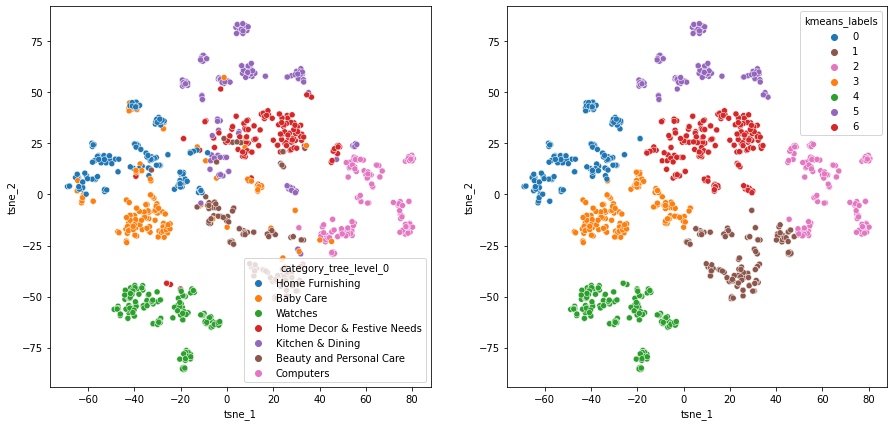

In [94]:
# Plot des samples dans t-SNE plot
data_kmbert['tsne_1'] = tsne_results_bert[:, 0]
data_kmbert['tsne_2'] = tsne_results_bert[:, 1]
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plot = sns.scatterplot(x="tsne_1",
                       y="tsne_2",
                       hue='category_tree_level_0',
                       palette='tab10',
                       data=data_kmbert,
                       legend="full")

color = {0: "tab:blue", 1:"tab:brown", 2:"tab:pink", 3:"tab:orange",
          4:"tab:green", 5:"tab:purple", 6:"tab:red"}
plt.subplot(1, 2, 2)
plot = sns.scatterplot(x="tsne_1",
                       y="tsne_2",
                       hue='kmeans_labels',
                       palette=color,
                       data=data_kmbert,
                       legend="full")

plt.savefig("w2v_tsne.png", bbox_inches="tight")
plt.show()

In [225]:
scores['BERT'] = ARI
results_txt['BERT']= tsne_results_bert

# III. 1. Traitement des images

In [345]:
path = r"/Users/vonhattam/Data science/Projet 6/Images/"
list_photos = [data['image'][i] for i in range(data.shape[0])]
print(len(list_photos))

1050


In [346]:
import cv2
height = []
width = []
for x in range(len(list_photos)):
    image = cv2.imread(path+list_photos[x])
    height.append(image.shape[0])
    width.append(image.shape[1])
print(f"Hauteur maximum:{max(height)} ---- Largeur maximum: {max(width)}")
print(f"Hauteur minimum:{min(height)} ---- Largeur minimum: {min(width)}")

Hauteur maximum:11042 ---- Largeur maximum: 8484
Hauteur minimum:160 ---- Largeur minimum: 145


In [347]:
list_labels = data["category_tree_level_0"].value_counts().index.to_list()
list_labels

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

In [348]:
from matplotlib.image import imread

def list_fct(name) :
    list_image_name = [data['image'][i] for i in range(data.shape[0])
                       if data["category_tree_level_0"][i]==name]
    return list_image_name

list_furnishing=list_fct("Home Furnishing")
list_baby=list_fct("Baby Care")
list_decor=list_fct("Home Decor & Festive Needs")
list_beauty=list_fct("Beauty and Personal Care")
list_computer=list_fct("Computers")
list_watches=list_fct("Watches")
list_kitchen=list_fct("Kitchen & Dining")

Home Furnishing


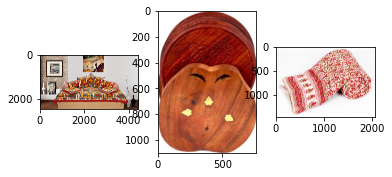

Baby Care


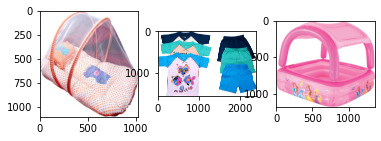

Watches


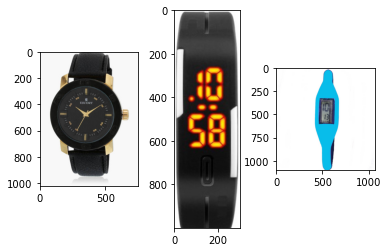

Home Decor & Festive Needs


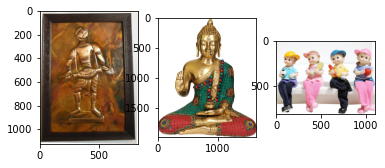

Kitchen & Dining


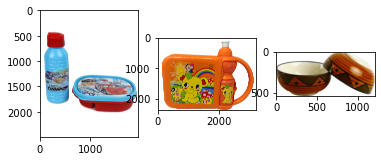

Beauty and Personal Care


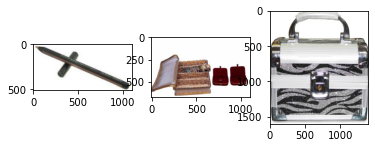

Computers


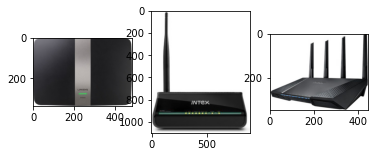

In [349]:
for name in list_labels :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

In [350]:
def resize_pad(image, size):
    """Fontion de resize des images à size*size avec padding"""
    import cv2
    
    if image.shape[0]>image.shape[1]:
        height = size
        width = int((height/image.shape[0])*image.shape[1])
        dsize = (width, height)
        image1 = cv2.resize(image, dsize)
        tp = 0
        bt = 0
        lft = int((size - image1.shape[1]))
        rgt = 0
        image2 = cv2.copyMakeBorder(image1,tp,bt,lft,rgt,
                                    cv2.BORDER_CONSTANT,value=[255, 255, 255])
    elif image.shape[0]<image.shape[1]:
        width = size
        height = int((width/image.shape[1])*image.shape[0])
        dsize = (width, height)
        image1 = cv2.resize(image, dsize)
        tp = int((size - image1.shape[0]))
        bt = 0
        lft = 0
        rgt = 0
        image2 = cv2.copyMakeBorder(image1,tp,bt,lft,rgt,
                                    cv2.BORDER_CONSTANT,value=[255, 255, 255])
    elif image.shape[0]==image.shape[1]:
        width = size
        height = int((width/image.shape[1])*image.shape[0])
        dsize = (width, height)
        image1 = cv2.resize(image, dsize)
        tp = 0
        bt = 0
        lft = 0
        rgt = 0
        image2 = cv2.copyMakeBorder(image1,tp,bt,lft,rgt,
                                    cv2.BORDER_CONSTANT,value=[255, 255, 255])
    return image2

Image brut


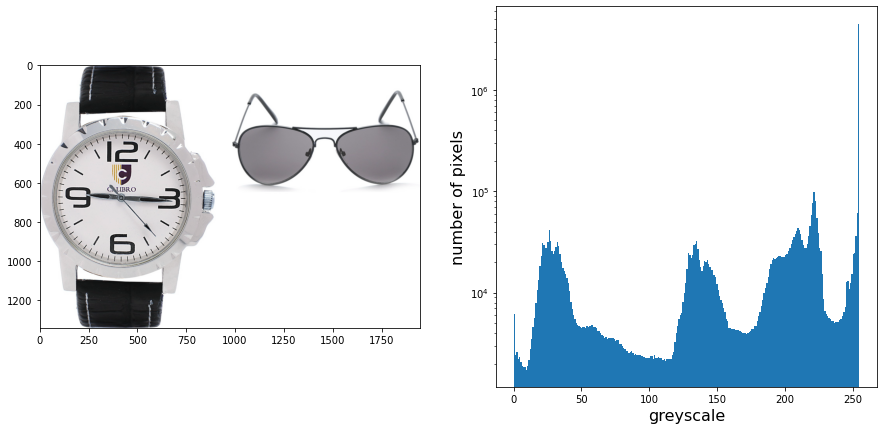

----------------------------------------------------------------------------------------




Image nouvelle taille avec padding


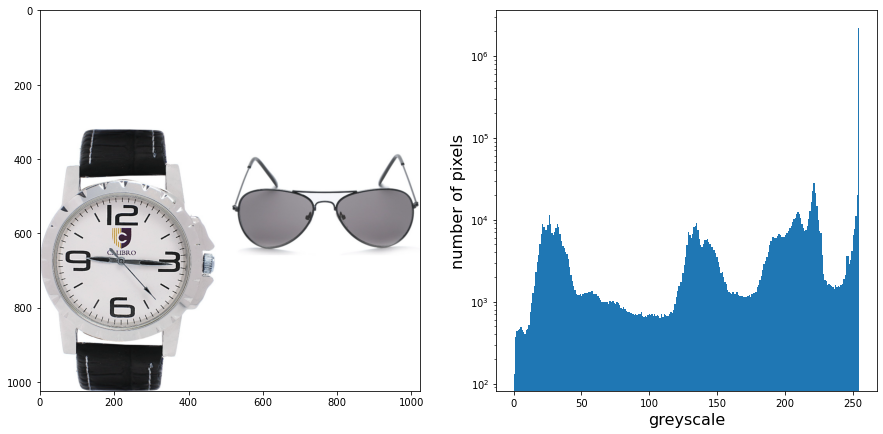

----------------------------------------------------------------------------------------




Image modifiée par autocontrast


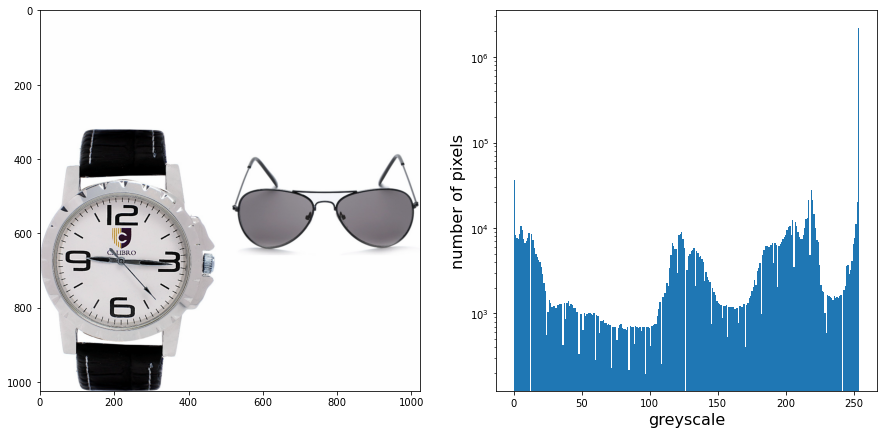

----------------------------------------------------------------------------------------




Equalisation des histograme


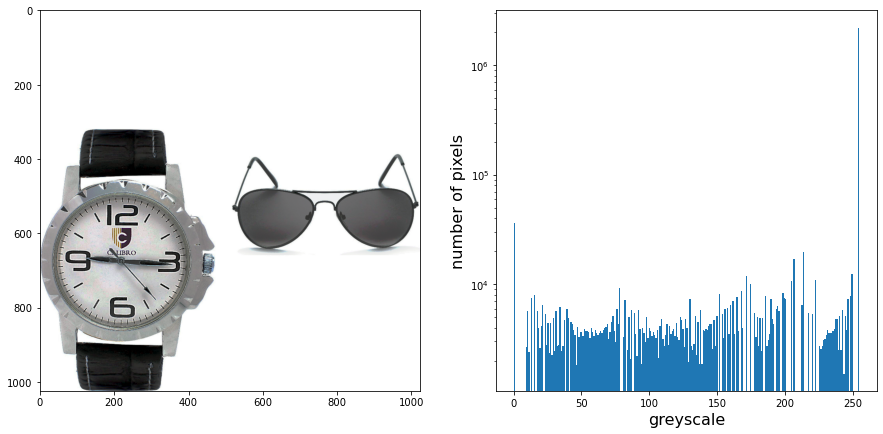

----------------------------------------------------------------------------------------




Image après supprimer le bruit


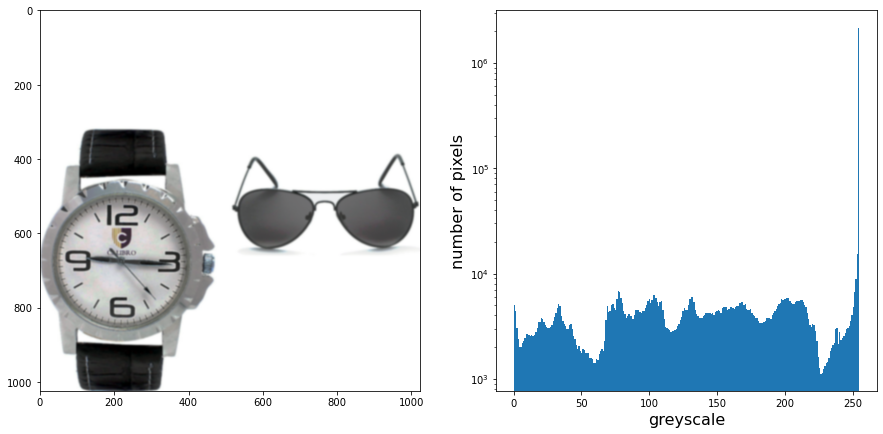

----------------------------------------------------------------------------------------






In [369]:
# les étapes traitements d'image

from PIL import Image, ImageOps, ImageFilter

image = cv2.imread(path+list_photos[10])
print('Image brut')
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(image)

plt.subplot(1, 2, 2)
tmp = np.array(image).flatten()
plt.hist(tmp, bins=256, log=(0,1))
plt.xlabel('greyscale', fontsize = 16)
plt.ylabel('number of pixels', fontsize = 16)
plt.show()
print('----------------------------------------------------------------------------------------\n\n\n\n')

image = resize_pad(image, 1024)      # resize 
print('Image nouvelle taille avec padding')
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
tmp = np.array(image).flatten()
plt.hist(tmp, bins=256, log=(0,1))
plt.xlabel('greyscale', fontsize = 16)
plt.ylabel('number of pixels', fontsize = 16)
plt.show()
print('----------------------------------------------------------------------------------------\n\n\n\n')

image = Image.fromarray(image)
image = ImageOps.autocontrast(image, cutoff=1) # remove 1% extreme lightest and darkest pixels then maximize image contrast
print('Image modifiée par autocontrast')
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
tmp = np.array(image).flatten()
plt.hist(tmp, bins=256, log=(0,1))
plt.xlabel('greyscale', fontsize = 16)
plt.ylabel('number of pixels', fontsize = 16)
plt.show()
print('----------------------------------------------------------------------------------------\n\n\n\n')

image = ImageOps.equalize(image) # equalize image histogram to creat a uniform distribution of grayscale
print('Equalisation des histograme')
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
tmp = np.array(image).flatten()
plt.hist(tmp, bins=256, log=(0,1))
plt.xlabel('greyscale', fontsize = 16)
plt.ylabel('number of pixels', fontsize = 16)
plt.show()
print('----------------------------------------------------------------------------------------\n\n\n\n')

image = image.filter(ImageFilter.GaussianBlur(2))
print('Image après supprimer le bruit')
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
tmp = np.array(image).flatten()
plt.hist(tmp, bins=256, log=(0,1))
plt.xlabel('greyscale', fontsize = 16)
plt.ylabel('number of pixels', fontsize = 16)
plt.show()
print('----------------------------------------------------------------------------------------\n\n\n\n')

In [106]:
def preprocess_image(image, size, theta):
    """This function resize image, optimize the contrast, then blur image.
    The input need to be ndarray"""
    img1 = resize_pad(image, size)
    img2 = Image.fromarray(img1)
    img3 = ImageOps.autocontrast(img2, cutoff=1)
    img4 = ImageOps.equalize(img3)
    img5 = img4.filter(ImageFilter.GaussianBlur(radius=theta))
    img_processed = np.array(img5)
    return img_processed

In [107]:
dir_image = r"/Users/vonhattam/Data science/Projet 6/Images"
dir_image_prepro = r"/Users/vonhattam/Data science/Projet 6/Image_Preprocessing"

In [108]:
# Traiter les images et enregistrer dans fichier Preprocessing

for imgname_ in data['image'].tolist():
    path_ = os.path.join(dir_image, imgname_)
    img_ = cv.imread(path_)
    img_processed_ = preprocess_image(img_, 1024, 2)
    new_path_ = os.path.join(dir_image_prepro, imgname_)
    cv.imwrite(new_path_, img_processed_)

# III. 2. Bag of feature (SIFT)

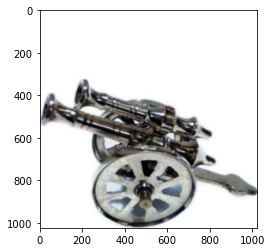

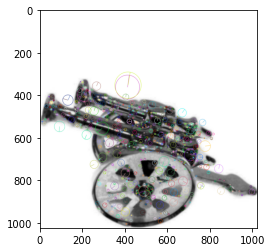

In [109]:
# SIFT: Scale-invariant feature transform
image_name = data['image'].loc[200]
path = os.path.join(dir_image_prepro, image_name)
# use opencv read image
img = cv.imread(path)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
sift = cv.SIFT_create()
kp = sift.detect(gray, None)
img_kp = cv.drawKeypoints(gray, kp, gray,
                          flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)
plt.show()
plt.imshow(img_kp)
plt.show()

In [148]:
# compute SIFT descriptor of preprocessed images
sift = cv.SIFT_create()
des_total = []
img_all = pd.DataFrame(data['image'])
img_all['descriptor_SIFT'] = 'initial'

for index, row in img_all.iterrows():
    imgname_ = row['image']
    path_ = os.path.join(dir_image_prepro, imgname_)
    gray_ = cv.imread(path_, cv.IMREAD_GRAYSCALE)
    kp_, des_ = sift.detectAndCompute(gray_, None)
    des_total.append(des_)
    row['descriptor_SIFT'] = des_

# descriptors for all images
des_total_arr = np.concatenate(des_total)
des_total_arr.shape

(1021458, 128)

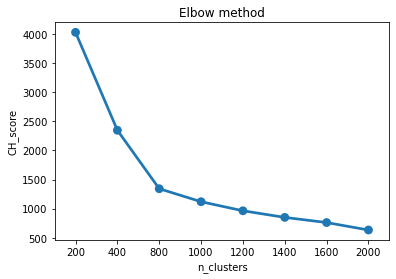

In [113]:
# check 1021458 descriptors clustering
CH_score = {}
for k in [200, 400, 800, 1000, 1200, 1400, 1600, 2000]:
    mkmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k,
                                 batch_size=2000, random_state=0)
    mkmeans.fit(des_total_arr)
    CH_score[k] = calinski_harabasz_score(des_total_arr, mkmeans.labels_)
    
ax = sns.pointplot(x=list(CH_score.keys()), y=list(CH_score.values()))
ax.set(xlabel='n_clusters', ylabel='CH_score', title='Elbow method')
plt.show()

In [149]:
from sklearn import cluster, metrics

# optimized number of clusters
temps1=time.time()

k = 1200
print("Nombre de clusters optimisés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k,
                                 batch_size=2000, random_state=0)
kmeans.fit(des_total_arr)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters optimisés :  1200
Création de 1200 clusters de descripteurs ...
temps de traitement kmeans :           106.79 secondes


In [150]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(des_total) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features_sift = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             5.01 secondes


In [226]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features_sift.shape)
pca = decomposition.PCA(n_components=0.95)
feat_pca= pca.fit_transform(im_features_sift)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 1200)
Dimensions dataset après réduction PCA :  (1050, 414)


In [227]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30,
                     random_state=6)
X_tsne_sift = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne_sift[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["category_tree_level_0"]
print(df_tsne.shape)

(1050, 3)


In [237]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne_sift)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


In [238]:
from sklearn.metrics import adjusted_rand_score

labels = data["category_tree_level_0"]
ARI = adjusted_rand_score(labels, cls.labels_)

print(f"ARI = {ARI}")

ARI = 0.03718903810190319


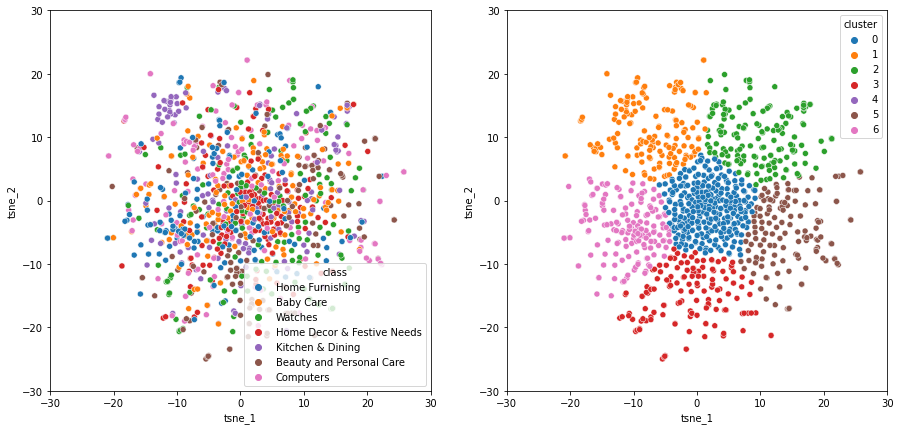

In [155]:
# Plot des samples dans t-SNE plot
df_tsne['tsne_1'] = X_tsne_sift[:, 0]
df_tsne['tsne_2'] = X_tsne_sift[:, 1]
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plot = sns.scatterplot(x="tsne_1",
                       y="tsne_2",
                       hue='class',
                       palette='tab10',
                       data=df_tsne,
                       legend="full")
plt.ylim([-30, 30])
plt.xlim([-30, 30])

plt.subplot(1, 2, 2)
plot = sns.scatterplot(x="tsne_1",
                       y="tsne_2",
                       hue='cluster',
                       palette='tab10',
                       data=df_tsne,
                       legend="full")
plt.ylim([-30, 30])
plt.xlim([-30, 30])
plt.savefig("sift_tsne.png", bbox_inches="tight")
plt.show()

In [239]:
scores['SIFT'] = ARI
results_img['SIFT']= X_tsne_sift

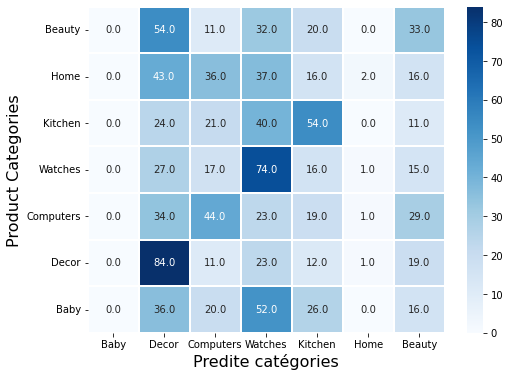

In [332]:
# Les catégories d'images sont encodés numériquement de 0 à 6
cat_encoder = LabelEncoder()
y_true = cat_encoder.fit_transform(data['category_tree_level_0'])

# Labels prédits par le meilleur algorithme
km = KMeans(n_clusters=data['category_tree_level_0'].nunique())
y_pred = km.fit_predict(results_img['SIFT'])

# Calcul de la Matrice de confusion
mat_conf = confusion_matrix(y_true, y_pred)

# transform matrice de confusion
corresp = np.argmax(mat_conf, axis=0)
labels = pd.Series(y_true, name="y_true").to_frame()
labels['y_pred'] = y_pred
labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])
mat_conf_transform = metrics.confusion_matrix(y_true, labels['y_pred_transform'])

# Mise sous forme de DataFrame
list_labels=['Baby','Decor','Computers','Watches','Kitchen','Home','Beauty']
mat_conf_df = pd.DataFrame(mat_conf_transform,index = [label for label in list_labels],
                  columns = [label for label in list_labels])
# Trace la matrice de confusion
fig = plt.figure(1, figsize=(8, 6))
sns.heatmap(mat_conf_df, annot=True, linewidths=.3, fmt='.1f', cmap="Blues")
plt.ylabel('Product Categories', fontsize = 16)
plt.xlabel('Predite catégories', fontsize = 16)
plt.ylim(0, 7)
plt.show()

# III. 3. ORB

In [156]:
# compute ORB descriptor of all preprocessed images
orb = cv.ORB_create()
des_total_ORB = []
img_all = pd.DataFrame(data['image'])
#img_all['descriptor_ORB'] = 'initial'

for index, row in img_all.iterrows():
    imgname_ = row['image']
    path_ = os.path.join(dir_image_prepro, imgname_)
    img_ = cv.imread(path_, cv.IMREAD_GRAYSCALE)
    kp_, des_ = orb.detectAndCompute(img_, None)
    des_total_ORB.append(des_)
    row['descriptor_ORB'] = des_

des_total_arr_ORB = np.concatenate(des_total_ORB)
des_total_arr_ORB.shape

(478620, 32)

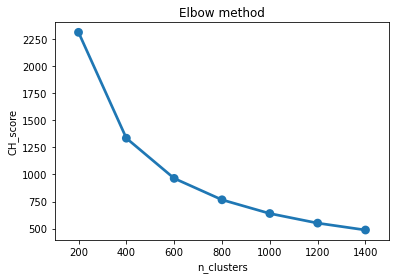

In [165]:
# Select the best n_cluster
CH_score = {}
for k in [200, 400, 600, 800, 1000, 1200, 1400]:
    mkmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k,
                                 batch_size=2000, random_state=0)
    mkmeans.fit(des_total_arr_ORB)
    CH_score[k] = calinski_harabasz_score(des_total_arr_ORB, mkmeans.labels_)
ax = sns.pointplot(x=list(CH_score.keys()), y=list(CH_score.values()))
ax.set(xlabel='n_clusters', ylabel='CH_score', title='Elbow method')
plt.show()

In [157]:
from sklearn import cluster, metrics

# optimized number of clusters
temps1=time.time()

k = 1200
print("Nombre de clusters optimisés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k,
                                 batch_size=2000, random_state=0)
kmeans.fit(des_total_arr_ORB)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters optimisés :  1200
Création de 1200 clusters de descripteurs ...
temps de traitement kmeans :            43.15 secondes


In [158]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(des_total_ORB) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features_ORB = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             2.13 secondes


In [231]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features_ORB.shape)
pca = decomposition.PCA(n_components=0.95)
feat_pca= pca.fit_transform(im_features_ORB)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 1200)
Dimensions dataset après réduction PCA :  (1050, 562)


In [232]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30,
                     random_state=6)
X_tsne_ORB = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne_sift[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["category_tree_level_0"]
print(df_tsne.shape)

(1050, 3)


In [233]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne_ORB)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


In [234]:
from sklearn.metrics import adjusted_rand_score

labels = data["category_tree_level_0"]
ARI = adjusted_rand_score(labels, cls.labels_)

print(f"ARI = {ARI}")

ARI = 0.01874489846368853


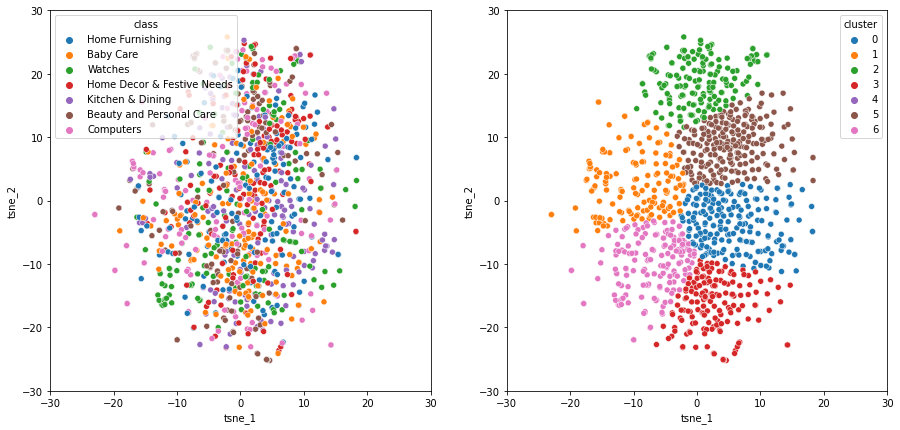

In [163]:
# Plot des samples dans t-SNE plot
df_tsne['tsne_1'] = X_tsne_ORB[:, 0]
df_tsne['tsne_2'] = X_tsne_ORB[:, 1]
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plot = sns.scatterplot(x="tsne_1",
                       y="tsne_2",
                       hue='class',
                       palette='tab10',
                       data=df_tsne,
                       legend="full")
plt.ylim([-30, 30])
plt.xlim([-30, 30])
plt.subplot(1, 2, 2)
plot = sns.scatterplot(x="tsne_1",
                       y="tsne_2",
                       hue='cluster',
                       palette='tab10',
                       data=df_tsne,
                       legend="full")
plt.ylim([-30, 30])
plt.xlim([-30, 30])
plt.savefig("sift_tsne.png", bbox_inches="tight")
plt.show()

In [236]:
scores['ORB'] = ARI
results_img['ORB']= X_tsne_ORB

# III. 4. CNN learning transfert

## Xception

In [191]:
from keras.applications.xception import Xception
# load model
model = Xception()
# summarize the model
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_19 (Add)                   (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_18[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_19[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_22 (A

In [192]:
model_cnn = Xception()
model_cnn = Model(inputs=model_cnn.inputs, outputs=model_cnn.layers[-2].output)
cnn_feature = []
for imgname_ in data['image']:
    path_ = os.path.join(dir_image_prepro, imgname_)
    img_ = load_img(path_, target_size=(299, 299)) # Xception input size
    img_ = img_to_array(img_)
    img_ = img_.reshape((1, img_.shape[0], img_.shape[1], img_.shape[2]))
    img_ = preprocess_input(img_) # preprocess image as CNN model want (normalize pixel value to (-1,1))
    y = model_cnn.predict(img_)
    cnn_feature.append(y)

bof_CNN_X = np.concatenate(cnn_feature)

1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 154ms/step


1/1 [==============================] - 0s 162ms/step


1/1 [==============================] - 0s 138ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 160ms/step


1/1 [==============================] - 0s 130ms/step


In [193]:
bof_CNN_X.shape

(1050, 2048)

In [197]:
ARI_score_10 = []
perplexity = [30, 20, 10]
variance = [0.8, 0.9, 0.95]
final_params_10 = []
for var in variance:
    for perp in perplexity:
        # Réduction de dimension par pca
        pca = PCA(n_components =var)
        pca_CNN_X = pca.fit_transform(bof_CNN_X)
        # Réduction de dimension par t-SNE
        tsne = TSNE(n_components=2, perplexity=20, random_state=5)
        tsne_cnn_X = tsne.fit_transform(pca_CNN_X) 
        # Clustering KMeans

        kmodel = KMeans(n_clusters=7, random_state=5)
        kmodel.fit(tsne_cnn_X)
        data_kmX = data.copy()
        data_kmX['kmeans_labels'] = kmodel.labels_

        # Calcul d'ARI 
        from sklearn.metrics import adjusted_rand_score


        ARI = adjusted_rand_score(data['category_tree_level_0'],
                                  data_kmX['kmeans_labels'])
    
        ARI_score_10.append(ARI)
        final_params_10.append((var, perp))

In [198]:
# Meilleurs score ARI et paramètres
print(f"Meilleur ARI = {max(ARI_score_10)}")

Meilleur ARI = 0.575023397792583


In [199]:
# Détermination des meilleurs paramètres pour max ARI
i10 = [i for i, j in enumerate(ARI_score_10) if j == max(ARI_score_10)]
for i in i10:
    print(f"n = {final_params_10[i]}")

n = (0.9, 30)
n = (0.9, 20)
n = (0.9, 10)


In [307]:
# Réduction de dimension par t-SNE
from sklearn.manifold import TSNE

pca = PCA(n_components =0.9)
pca_CNN_X = pca.fit_transform(bof_CNN_X)
# Réduction de dimension par t-SNE
tsne = TSNE(n_components=2, perplexity=20, random_state=5)
tsne_cnn_X = tsne.fit_transform(pca_CNN_X)
# Clustering KMeans
from sklearn.cluster import KMeans

kmodel = KMeans(n_clusters=7, random_state=5)
kmodel.fit(tsne_cnn_X)
data_kmX = data.copy()
data_kmX['kmeans_labels'] = kmodel.labels_
# Calcul d'ARI 
from sklearn.metrics import adjusted_rand_score


ARI = adjusted_rand_score(data['category_tree_level_0'],
                          data_kmX['kmeans_labels'])
print(f"ARI = {ARI}")

ARI = 0.575023397792583


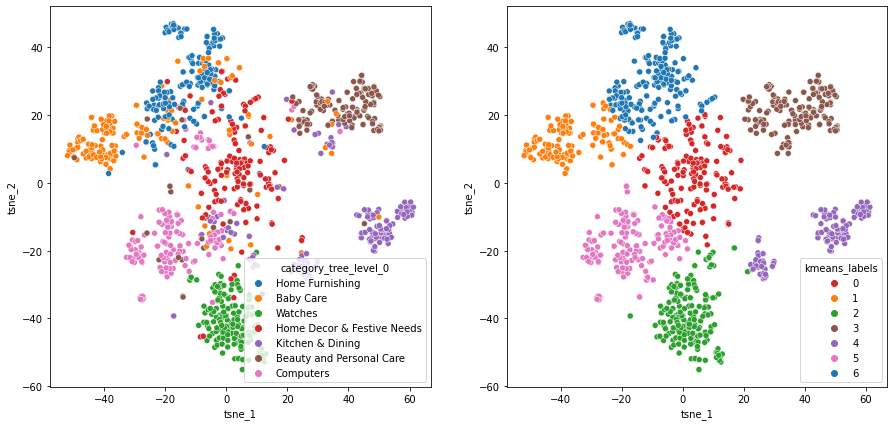

In [202]:
# Plot des samples dans t-SNE plot
data_kmX['tsne_1'] = tsne_cnn_X[:, 0]
data_kmX['tsne_2'] = tsne_cnn_X[:, 1]
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plot = sns.scatterplot(x="tsne_1",
                       y="tsne_2",
                       hue='category_tree_level_0',
                       palette='tab10',
                       data=data_kmX,
                       legend="full")

color = {0: "tab:red", 1:"tab:orange", 2:"tab:green", 3:"tab:brown",
          4:"tab:purple", 5:"tab:pink", 6:"tab:blue"}
plt.subplot(1, 2, 2)
plot = sns.scatterplot(x="tsne_1",
                       y="tsne_2",
                       hue='kmeans_labels',
                       palette=color,
                       data=data_kmX,
                       legend="full")

plt.show()

In [308]:
scores['Xception'] = ARI
results_img['Xception']= tsne_cnn_X

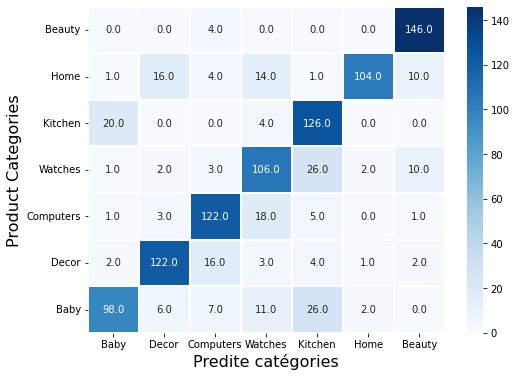

In [333]:
# Les catégories d'images sont encodés numériquement de 0 à 6
cat_encoder = LabelEncoder()
y_true = cat_encoder.fit_transform(data['category_tree_level_0'])

# Labels prédits par le meilleur algorithme
km = KMeans(n_clusters=data['category_tree_level_0'].nunique())
y_pred = km.fit_predict(results_img['Xception'])

# Calcul de la Matrice de confusion
mat_conf = confusion_matrix(y_true, y_pred)

# transform matrice de confusion
corresp = np.argmax(mat_conf, axis=0)
labels = pd.Series(y_true, name="y_true").to_frame()
labels['y_pred'] = y_pred
labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])
mat_conf_transform = metrics.confusion_matrix(y_true, labels['y_pred_transform'])

# Mise sous forme de DataFrame
list_labels=['Baby','Decor','Computers','Watches','Kitchen','Home','Beauty']
mat_conf_df = pd.DataFrame(mat_conf_transform,index = [label for label in list_labels],
                  columns = [label for label in list_labels])
# Trace la matrice de confusion
fig = plt.figure(1, figsize=(8, 6))
sns.heatmap(mat_conf_df, annot=True, linewidths=.3, fmt='.1f', cmap="Blues")
plt.ylabel('Product Categories', fontsize = 16)
plt.xlabel('Predite catégories', fontsize = 16)
plt.ylim(0, 7)
plt.show()

## VGG 

In [171]:
from keras.applications.vgg16 import VGG16
# load model
model = VGG16()
# summarize the model
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [173]:
from keras.models import Model
model_cnn = VGG16()
model_cnn = Model(inputs=model_cnn.inputs, outputs=model_cnn.layers[-2].output)
cnn_feature = []
for imgname_ in data['image']:
    path_ = os.path.join(dir_image_prepro, imgname_)
    img_ = load_img(path_, target_size=(224, 224)) # vgginput size
    img_ = img_to_array(img_)
    img_ = img_.reshape((1, img_.shape[0], img_.shape[1], img_.shape[2]))
    img_ = preprocess_input(img_) # preprocess image as CNN model want (normalize pixel value to (-1,1))
    y = model_cnn.predict(img_)
    cnn_feature.append(y)

bof_CNN_VGG = np.concatenate(cnn_feature)

1/1 [==============================] - 0s 210ms/step


1/1 [==============================] - 0s 204ms/step


1/1 [==============================] - 0s 216ms/step


1/1 [==============================] - 0s 208ms/step


1/1 [==============================] - 0s 232ms/step


1/1 [==============================] - 0s 239ms/step


1/1 [==============================] - 0s 213ms/step


In [174]:
bof_CNN_VGG.shape

(1050, 4096)

In [182]:
ARI_score_9 = []
perplexity = [30, 20, 10]
variance = [0.8, 0.9, 0.95]
final_params_9 = []
for var in variance:
    for perp in perplexity:
        # Réduction de dimension par pca
        pca = PCA(n_components =var)
        pca_CNN_VGG = pca.fit_transform(bof_CNN_VGG)
        # Réduction de dimension par t-SNE
        tsne = TSNE(n_components=2, perplexity=20, random_state=5)
        tsne_cnn_VGG = tsne.fit_transform(pca_CNN_VGG) 
        # Clustering KMeans

        kmodel = KMeans(n_clusters=7, random_state=5)
        kmodel.fit(tsne_cnn_VGG)
        data_kmvgg = data.copy()
        data_kmvgg['kmeans_labels'] = kmodel.labels_

        # Calcul d'ARI 
        from sklearn.metrics import adjusted_rand_score


        ARI = adjusted_rand_score(data['category_tree_level_0'],
                                  data_kmvgg['kmeans_labels'])
    
        ARI_score_9.append(ARI)
        final_params_9.append((var, perp))

In [183]:
# Meilleurs score ARI et paramètres
print(f"Meilleur ARI = {max(ARI_score_9)}")

Meilleur ARI = 0.3915818849777036


In [184]:
# Détermination des meilleurs paramètres pour max ARI
i9 = [i for i, j in enumerate(ARI_score_9) if j == max(ARI_score_9)]
for i in i9:
    print(f"n = {final_params_9[i]}")

n = (0.9, 30)
n = (0.9, 20)
n = (0.9, 10)


In [303]:
# Réduction de dimension par t-SNE
from sklearn.manifold import TSNE

pca = PCA(n_components =0.9)
pca_CNN_VGG = pca.fit_transform(bof_CNN_VGG)
# Réduction de dimension par t-SNE
tsne = TSNE(n_components=2, perplexity=20, random_state=5)
tsne_cnn_VGG = tsne.fit_transform(pca_CNN_VGG)  

# Clustering KMeans
from sklearn.cluster import KMeans

kmodel = KMeans(n_clusters=7, random_state=5)
kmodel.fit(tsne_cnn_VGG)
data_kmvgg = data.copy()
data_kmvgg['kmeans_labels'] = kmodel.labels_

# Calcul d'ARI 
from sklearn.metrics import adjusted_rand_score


ARI = adjusted_rand_score(data['category_tree_level_0'],
                          data_kmvgg['kmeans_labels'])
print(f"ARI = {ARI}")

ARI = 0.3915818849777036


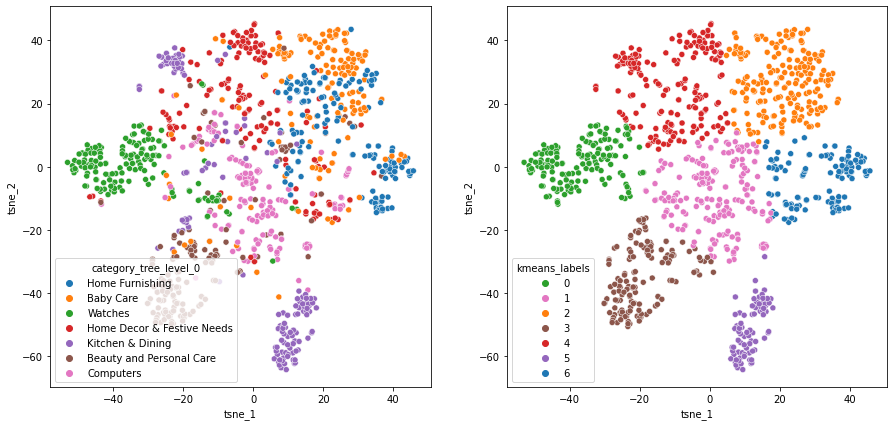

In [190]:
# Plot des samples dans t-SNE plot
data_kmvgg['tsne_1'] = tsne_cnn_VGG[:, 0]
data_kmvgg['tsne_2'] = tsne_cnn_VGG[:, 1]
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plot = sns.scatterplot(x="tsne_1",
                       y="tsne_2",
                       hue='category_tree_level_0',
                       palette='tab10',
                       data=data_kmvgg,
                       legend="full")

color = {0: "tab:green", 1:"tab:pink", 2:"tab:orange", 3:"tab:brown",
          4:"tab:red", 5:"tab:purple", 6:"tab:blue"}
plt.subplot(1, 2, 2)
plot = sns.scatterplot(x="tsne_1",
                       y="tsne_2",
                       hue='kmeans_labels',
                       palette=color,
                       data=data_kmvgg,
                       legend="full")

plt.show()

In [304]:
scores['VGG'] = ARI
results_img['VGG']= tsne_cnn_VGG

# IV. Combination Texte + Image

In [309]:
from sklearn.preprocessing import StandardScaler
# Pour chaque méthode de traitement des  images
for name_method_img, data_img in results_img.items() : 
    # Pour chaque méthode de traitement des textes
    for name_method_text, data_text in results_txt.items() :
        # Concaténation du nom des deux méthodes
        name_method = name_method_text + " & " + name_method_img
        # Concaténation des données textes et images
        X_concat = np.concatenate((data_text, data_img), axis=1)
        # Normalisation des données
        X_std = StandardScaler().fit_transform(X_concat) 
        
        kmodel = KMeans(n_clusters=7, random_state=5)
        kmodel.fit(X_std)
        data_km = data.copy()
        data_km['kmeans_labels'] = kmodel.labels_

        # Calcul d'ARI 
        ARI = adjusted_rand_score(data['category_tree_level_0'],
                                  data_km['kmeans_labels'])
        
        scores[name_method] = ARI

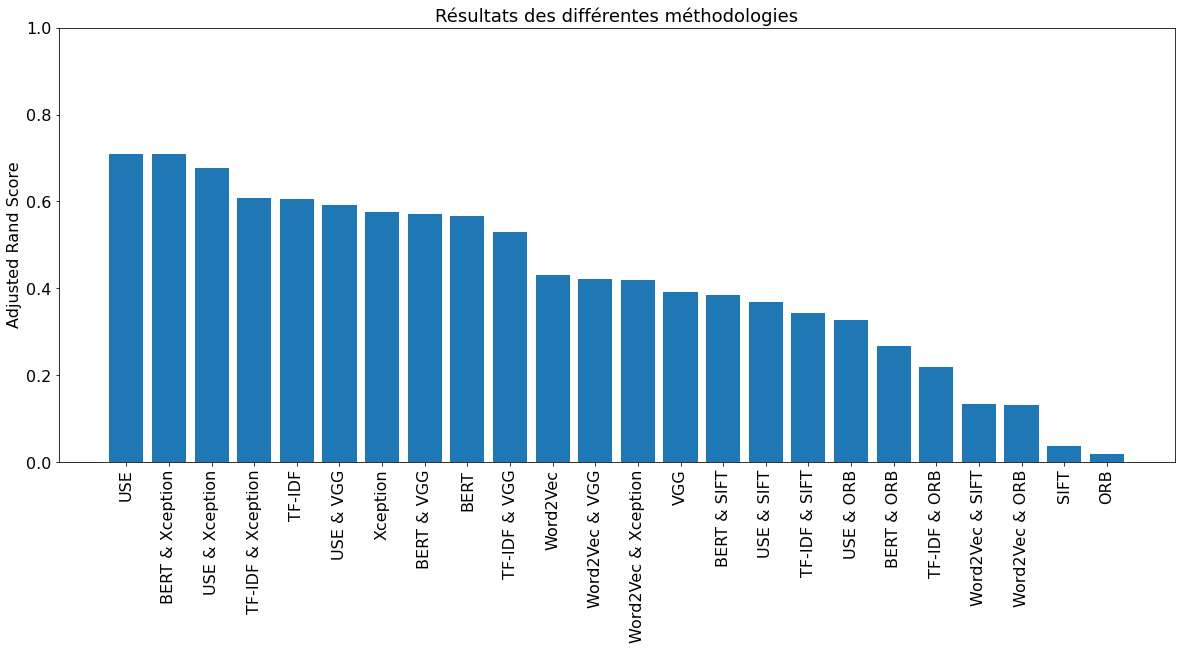

In [310]:
# Tracer la figure ARI en fonction des différentes méthodologies
fig = plt.figure(1, figsize=(20, 8))
df_scores = pd.DataFrame.from_dict(scores, orient='index').sort_values(by =0, ascending = False)
df_scores = df_scores.reset_index()
df_scores.columns =['method', 'score']
plt.bar(range(len(df_scores)), df_scores.score, align='center')

plt.ylim([0, 1])
plt.ylabel('Adjusted Rand Score', fontsize = 16)
plt.yticks(fontsize = 16)
plt.title("Résultats des différentes méthodologies", fontsize = 18)
plt.xticks(range(len(df_scores)), df_scores.method, rotation='vertical', fontsize = 16)
plt.show()